<a href="https://colab.research.google.com/github/lebro-23/covid-19-hackathon/blob/master/CovidPredictionsByState.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
uri = 'https://covidtracking.com/api/v1/states/daily.csv'
data = pd.read_csv(uri)

In [4]:
data.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200725,AK,2868.0,202198.0,NaN,38.0,NaN,NaN,NaN,2.0,NaN,815.0,A,7/25/2020 00:00,2020-07-25T00:00:00Z,07/24 20:00,20.0,NaN,2020-07-25T00:00:00Z,205066.0,NaN,NaN,2868.0,20.0,NaN,2,120,4374,205066,205066,4494,205066,1,0,5f2c5ca08d30c7fa77bfd21e75840efa1435f3cd,0,0,0,0,0,NaN
1,20200725,AL,78130.0,563481.0,NaN,1425.0,9157.0,NaN,1069.0,NaN,567.0,32510.0,B,7/25/2020 11:00,2020-07-25T11:00:00Z,07/25 07:00,1456.0,9157.0,2020-07-25T11:00:00Z,639795.0,NaN,NaN,76314.0,1413.0,43.0,1,2125,10502,641611,641611,12627,641611,18,0,8d1bda5ff4d4985142b55becccbea692e56abfda,0,0,0,0,0,NaN
2,20200725,AR,37249.0,424215.0,NaN,497.0,2361.0,NaN,NaN,109.0,329.0,29827.0,A+,7/25/2020 00:00,2020-07-25T00:00:00Z,07/24 20:00,394.0,2361.0,2020-07-25T00:00:00Z,461464.0,NaN,NaN,37249.0,NaN,NaN,5,0,0,461464,461464,0,461464,0,0,a3452a99a044e2e12f08a21b96dbef0d9362e5c2,0,0,0,0,0,NaN
3,20200725,AS,0.0,1037.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,7/16/2020 00:00,2020-07-16T00:00:00Z,07/15 20:00,0.0,NaN,2020-07-16T00:00:00Z,NaN,NaN,NaN,0.0,NaN,NaN,60,0,0,1037,1037,0,1037,0,0,0d7a633be32b1ba4de5e5b83e4541495d606dc79,0,0,0,0,0,NaN
4,20200725,AZ,160041.0,697568.0,NaN,2758.0,7627.0,842.0,NaN,594.0,NaN,20566.0,A+,7/25/2020 00:00,2020-07-25T00:00:00Z,07/24 20:00,3286.0,7627.0,2020-07-25T00:00:00Z,857609.0,NaN,NaN,137710.0,2431.0,152.0,4,3740,17052,857609,857609,20792,857609,144,166,086654feacad18d4c1af2297f08891f51d9cbcc2,0,0,0,0,0,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7969 entries, 0 to 7968
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      7969 non-null   int64  
 1   state                     7969 non-null   object 
 2   positive                  7954 non-null   float64
 3   negative                  7813 non-null   float64
 4   pending                   1046 non-null   float64
 5   hospitalizedCurrently     5405 non-null   float64
 6   hospitalizedCumulative    4223 non-null   float64
 7   inIcuCurrently            2742 non-null   float64
 8   inIcuCumulative           1137 non-null   float64
 9   onVentilatorCurrently     2402 non-null   float64
 10  onVentilatorCumulative    402 non-null    float64
 11  recovered                 4838 non-null   float64
 12  dataQualityGrade          6868 non-null   object 
 13  lastUpdateEt              7625 non-null   object 
 14  dateModi

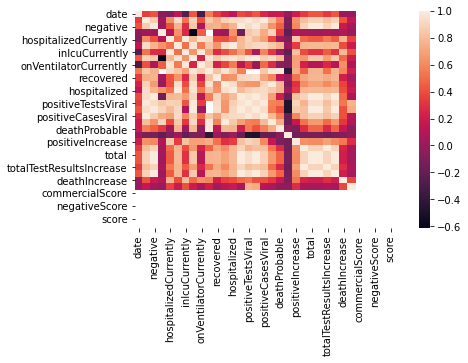

In [6]:
fig_dims = (6, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(data.corr())
plt.show()


In [7]:
num_features = data.select_dtypes(include= ["int64", "float64"]).columns
print("Number of Numerical Features:", len(num_features))

Number of Numerical Features: 34


In [8]:
cat_features = data.select_dtypes(include= ["object"]).columns
print("Number of Categorical Features:", len(cat_features))

Number of Categorical Features: 7


In [9]:
data.isnull().sum()

date                           0
state                          0
positive                      15
negative                     156
pending                     6923
hospitalizedCurrently       2564
hospitalizedCumulative      3746
inIcuCurrently              5227
inIcuCumulative             6832
onVentilatorCurrently       5567
onVentilatorCumulative      7567
recovered                   3131
dataQualityGrade            1101
lastUpdateEt                 344
dateModified                 344
checkTimeEt                  344
death                        698
hospitalized                3746
dateChecked                  344
totalTestsViral             5273
positiveTestsViral          6982
negativeTestsViral          6955
positiveCasesViral          3200
deathConfirmed              5479
deathProbable               6391
fips                           0
positiveIncrease               0
negativeIncrease               0
total                          0
totalTestResults               0
totalTestR

In [10]:
import missingno as msno

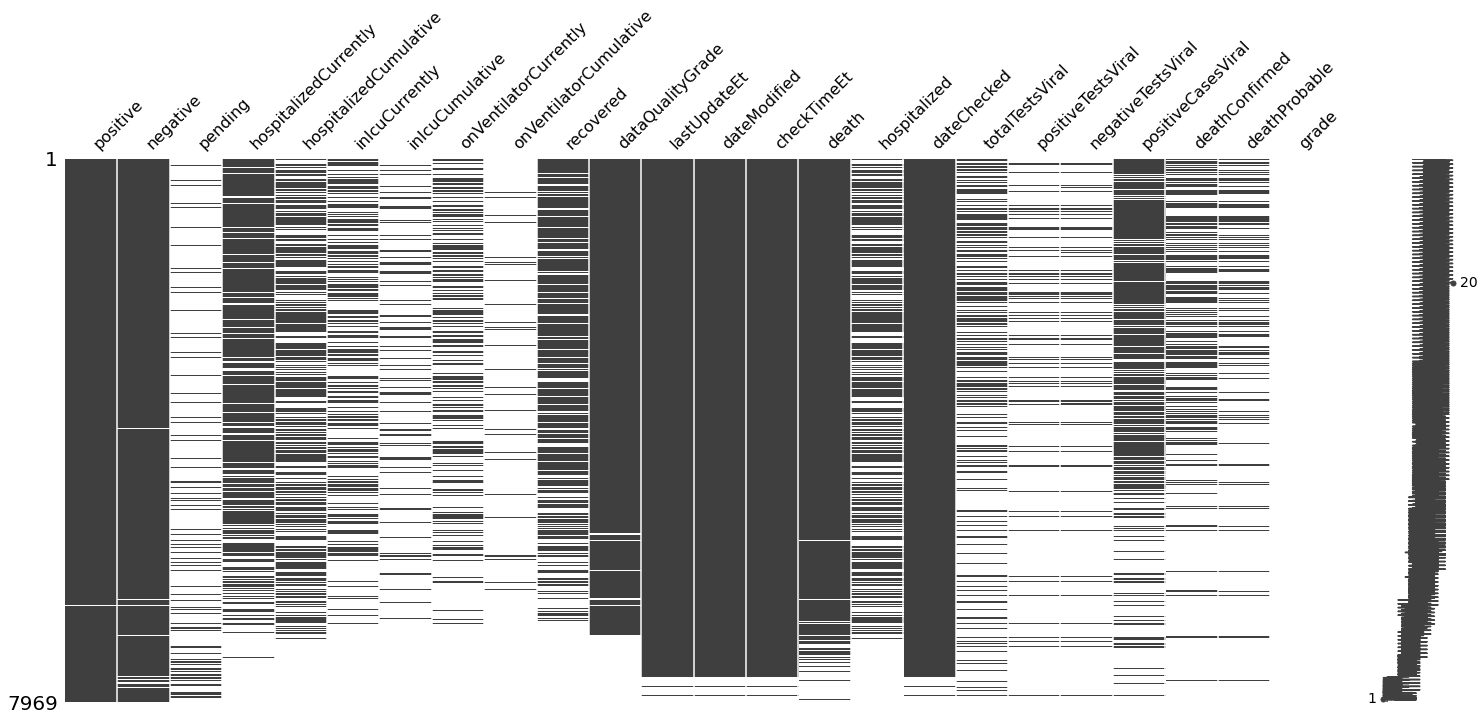

In [11]:
missing_data = data.columns[data.isnull().any()].tolist()
msno.matrix(data[missing_data])

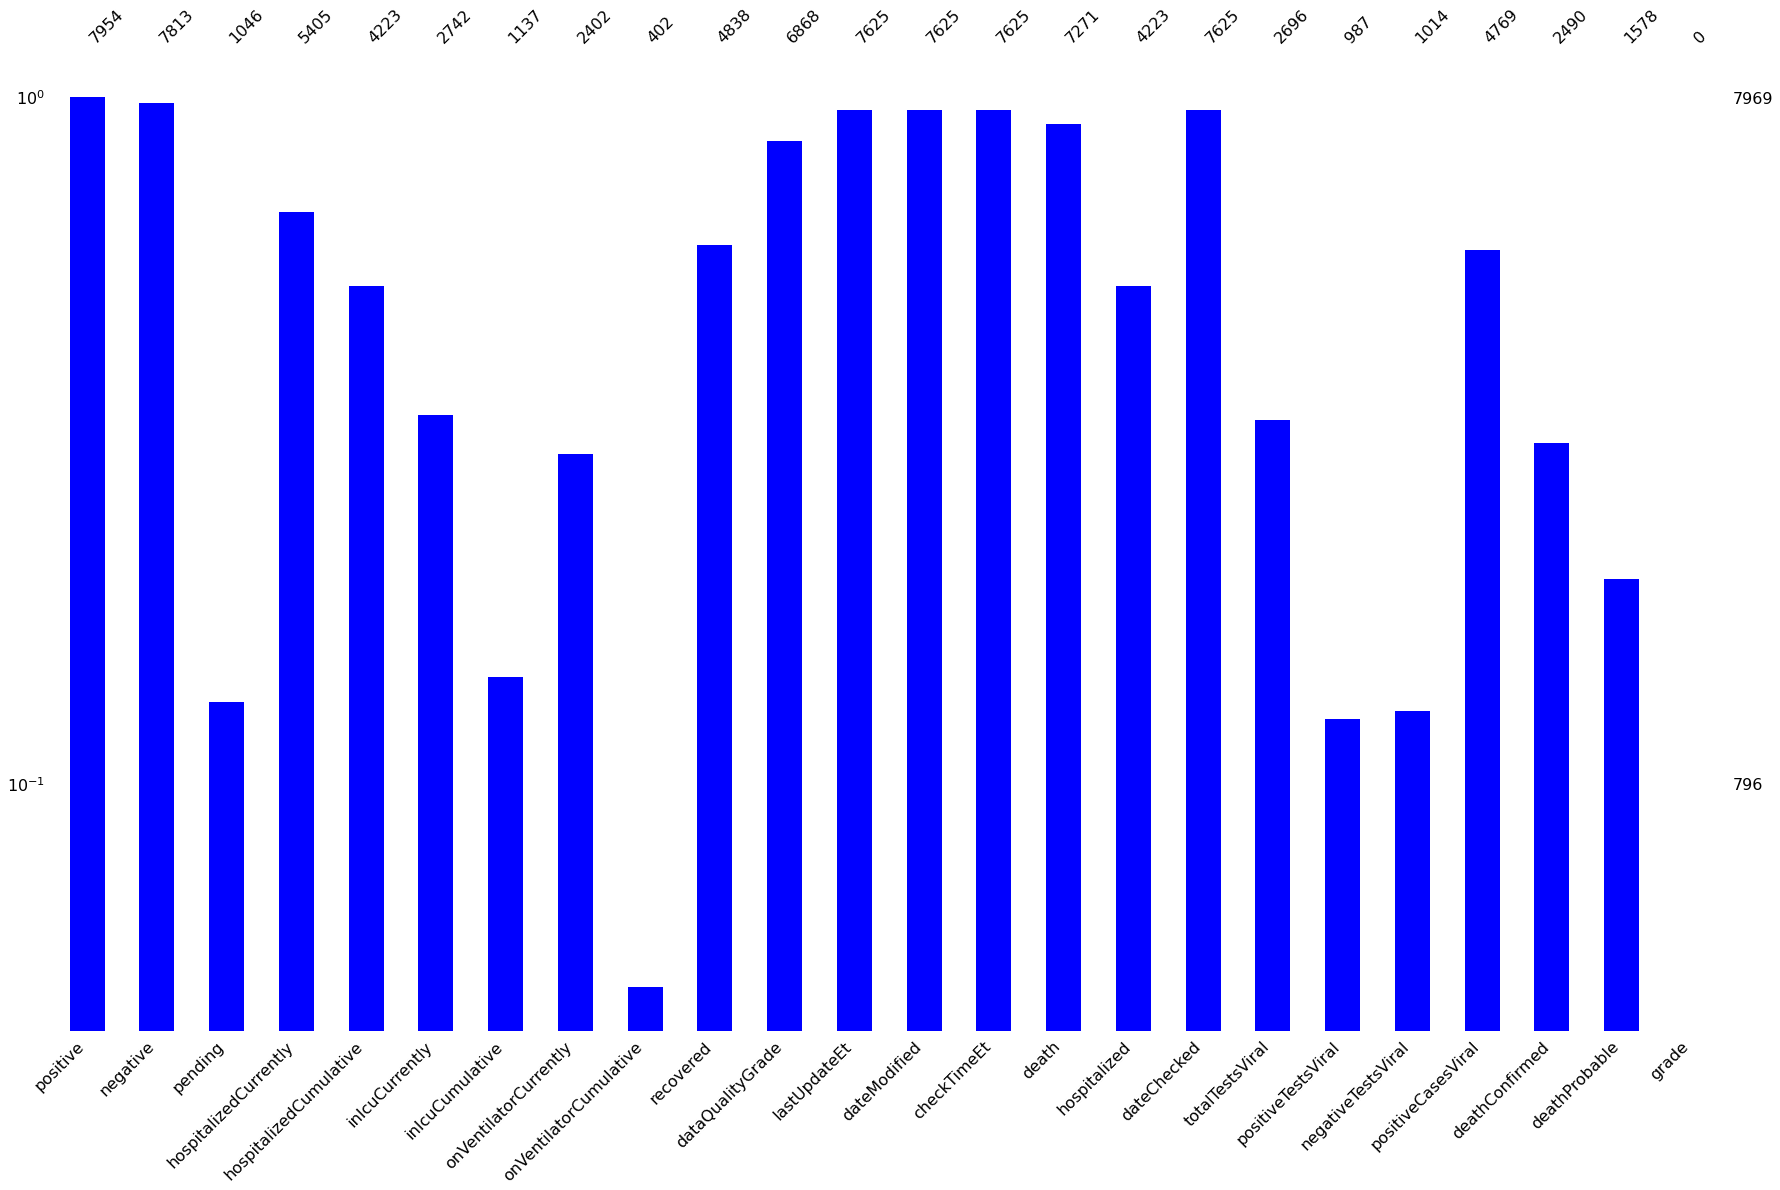

In [12]:
msno.bar(data[missing_data], color="blue", log=True, figsize=(30,18))

In [13]:
def missing_data_Method(df):
    missing = df.isnull().sum()
    available = df.count()
    total = (missing + available)
    percent = (df.isnull().sum()/df.isnull().count()*100).round(4)
    return pd.concat([missing, available, total, percent], axis=1, keys=['Missing', 'Available', 'Total', 'Missing_Percent']).sort_values(['Missing'], ascending=False)

In [14]:
missing_values_div = missing_data_Method(data)
missing_values_div

,Missing,Available,Total,Missing_Percent
grade,7969,0,7969,100.0000
onVentilatorCumulative,7567,402,7969,94.9555
positiveTestsViral,6982,987,7969,87.6145
negativeTestsViral,6955,1014,7969,87.2757
pending,6923,1046,7969,86.8741
inIcuCumulative,6832,1137,7969,85.7322
deathProbable,6391,1578,7969,80.1983
onVentilatorCurrently,5567,2402,7969,69.8582
deathConfirmed,5479,2490,7969,68.7539
totalTestsViral,5273,2696,7969,66.1689


In [15]:
columns_with_less_NAN = missing_values_div[missing_values_div.Missing_Percent <80].index

In [16]:
sub_data = data[columns_with_less_NAN]

In [17]:
sub_data.head()

,onVentilatorCurrently,deathConfirmed,totalTestsViral,inIcuCurrently,hospitalized,hospitalizedCumulative,positiveCasesViral,recovered,hospitalizedCurrently,dataQualityGrade,death,dateModified,checkTimeEt,lastUpdateEt,dateChecked,negative,positive,state,score,positiveScore,negativeScore,negativeRegularScore,commercialScore,hash,hospitalizedIncrease,deathIncrease,posNeg,totalTestResultsIncrease,totalTestResults,total,negativeIncrease,positiveIncrease,fips,date
0,2.0,20.0,205066.0,NaN,NaN,NaN,2868.0,815.0,38.0,A,20.0,2020-07-25T00:00:00Z,07/24 20:00,7/25/2020 00:00,2020-07-25T00:00:00Z,202198.0,2868.0,AK,0,0,0,0,0,5f2c5ca08d30c7fa77bfd21e75840efa1435f3cd,0,1,205066,4494,205066,205066,4374,120,2,20200725
1,NaN,1413.0,639795.0,NaN,9157.0,9157.0,76314.0,32510.0,1425.0,B,1456.0,2020-07-25T11:00:00Z,07/25 07:00,7/25/2020 11:00,2020-07-25T11:00:00Z,563481.0,78130.0,AL,0,0,0,0,0,8d1bda5ff4d4985142b55becccbea692e56abfda,0,18,641611,12627,641611,641611,10502,2125,1,20200725
2,109.0,NaN,461464.0,NaN,2361.0,2361.0,37249.0,29827.0,497.0,A+,394.0,2020-07-25T00:00:00Z,07/24 20:00,7/25/2020 00:00,2020-07-25T00:00:00Z,424215.0,37249.0,AR,0,0,0,0,0,a3452a99a044e2e12f08a21b96dbef0d9362e5c2,0,0,461464,0,461464,461464,0,0,5,20200725
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,C,0.0,2020-07-16T00:00:00Z,07/15 20:00,7/16/2020 00:00,2020-07-16T00:00:00Z,1037.0,0.0,AS,0,0,0,0,0,0d7a633be32b1ba4de5e5b83e4541495d606dc79,0,0,1037,0,1037,1037,0,0,60,20200725
4,594.0,2431.0,857609.0,842.0,7627.0,7627.0,137710.0,20566.0,2758.0,A+,3286.0,2020-07-25T00:00:00Z,07/24 20:00,7/25/2020 00:00,2020-07-25T00:00:00Z,697568.0,160041.0,AZ,0,0,0,0,0,086654feacad18d4c1af2297f08891f51d9cbcc2,166,144,857609,20792,857609,857609,17052,3740,4,20200725


In [18]:
num_sub_data = sub_data.select_dtypes(include=["int64", "float64"])

In [19]:
from fancyimpute import KNN

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


In [20]:
KNN =KNN(2)

In [21]:
num_data_array = KNN.fit_transform(num_sub_data)

Imputing row 1/7969 with 3 missing, elapsed time: 15.336
Imputing row 101/7969 with 1 missing, elapsed time: 15.358
Imputing row 201/7969 with 4 missing, elapsed time: 15.380
Imputing row 301/7969 with 5 missing, elapsed time: 15.402
Imputing row 401/7969 with 5 missing, elapsed time: 15.424
Imputing row 501/7969 with 3 missing, elapsed time: 15.445
Imputing row 601/7969 with 2 missing, elapsed time: 15.467
Imputing row 701/7969 with 0 missing, elapsed time: 15.490
Imputing row 801/7969 with 3 missing, elapsed time: 15.513
Imputing row 901/7969 with 0 missing, elapsed time: 15.535
Imputing row 1001/7969 with 3 missing, elapsed time: 15.561
Imputing row 1101/7969 with 3 missing, elapsed time: 15.586
Imputing row 1201/7969 with 2 missing, elapsed time: 15.609
Imputing row 1301/7969 with 5 missing, elapsed time: 15.633
Imputing row 1401/7969 with 3 missing, elapsed time: 15.656
Imputing row 1501/7969 with 2 missing, elapsed time: 15.679
Imputing row 1601/7969 with 4 missing, elapsed time:

In [22]:
num_data_array

array([[2.00000000e+00, 2.00000000e+01, 2.05066000e+05, ...,
        1.20000000e+02, 2.00000000e+00, 2.02007250e+07],
       [2.62999996e+02, 1.41300000e+03, 6.39795000e+05, ...,
        2.12500000e+03, 1.00000000e+00, 2.02007250e+07],
       [1.09000000e+02, 2.66911676e+03, 4.61464000e+05, ...,
        0.00000000e+00, 5.00000000e+00, 2.02007250e+07],
       ...,
       [1.99999991e+00, 0.00000000e+00, 4.49701903e+00, ...,
        0.00000000e+00, 5.30000000e+01, 2.02001240e+07],
       [2.00000000e+00, 0.00000000e+00, 4.49703658e+00, ...,
        0.00000000e+00, 5.30000000e+01, 2.02001230e+07],
       [2.00000000e+00, 0.00000000e+00, 4.49705370e+00, ...,
        0.00000000e+00, 5.30000000e+01, 2.02001220e+07]])

In [23]:
num_data_FillNa = pd.DataFrame(data=num_data_array, columns=num_sub_data.columns, index=num_sub_data.index)

In [24]:
num_data_FillNa.isnull().sum()

onVentilatorCurrently       0
deathConfirmed              0
totalTestsViral             0
inIcuCurrently              0
hospitalized                0
hospitalizedCumulative      0
positiveCasesViral          0
recovered                   0
hospitalizedCurrently       0
death                       0
negative                    0
positive                    0
score                       0
positiveScore               0
negativeScore               0
negativeRegularScore        0
commercialScore             0
hospitalizedIncrease        0
deathIncrease               0
posNeg                      0
totalTestResultsIncrease    0
totalTestResults            0
total                       0
negativeIncrease            0
positiveIncrease            0
fips                        0
date                        0
dtype: int64

In [25]:
cat_sub_data = sub_data.select_dtypes(include=["object"])

In [26]:
cat_sub_data.count()

dataQualityGrade    6868
dateModified        7625
checkTimeEt         7625
lastUpdateEt        7625
dateChecked         7625
state               7969
hash                7969
dtype: int64

In [27]:
cat_sub_data.isna().sum()

dataQualityGrade    1101
dateModified         344
checkTimeEt          344
lastUpdateEt         344
dateChecked          344
state                  0
hash                   0
dtype: int64

In [28]:
cat_missing_count = missing_data_Method(cat_sub_data)
cat_missing_count

,Missing,Available,Total,Missing_Percent
dataQualityGrade,1101,6868,7969,13.8160
dateModified,344,7625,7969,4.3167
checkTimeEt,344,7625,7969,4.3167
lastUpdateEt,344,7625,7969,4.3167
dateChecked,344,7625,7969,4.3167
state,0,7969,7969,0.0000
hash,0,7969,7969,0.0000


In [29]:
#Removing reduntant columns
state = pd.DataFrame(data = cat_sub_data.state, columns= ["state"] )

In [30]:
state.shape

(7969, 1)

In [31]:
state.head()

,state
0,AK
1,AL
2,AR
3,AS
4,AZ


In [32]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
state["state"] = labelEncoder.fit_transform(state["state"].astype(str))

In [33]:
state.head()

,state
0,0
1,1
2,2
3,3
4,4


In [34]:
data_clean = num_data_FillNa.copy()

In [35]:
data_clean['state'] = state["state"] 

In [36]:
data_clean.shape

(7969, 28)

In [37]:
#Remove all missing values
data_clean.isnull().sum()

onVentilatorCurrently       0
deathConfirmed              0
totalTestsViral             0
inIcuCurrently              0
hospitalized                0
hospitalizedCumulative      0
positiveCasesViral          0
recovered                   0
hospitalizedCurrently       0
death                       0
negative                    0
positive                    0
score                       0
positiveScore               0
negativeScore               0
negativeRegularScore        0
commercialScore             0
hospitalizedIncrease        0
deathIncrease               0
posNeg                      0
totalTestResultsIncrease    0
totalTestResults            0
total                       0
negativeIncrease            0
positiveIncrease            0
fips                        0
date                        0
state                       0
dtype: int64

In [38]:
data_clean.head()

,onVentilatorCurrently,deathConfirmed,totalTestsViral,inIcuCurrently,hospitalized,hospitalizedCumulative,positiveCasesViral,recovered,hospitalizedCurrently,death,negative,positive,score,positiveScore,negativeScore,negativeRegularScore,commercialScore,hospitalizedIncrease,deathIncrease,posNeg,totalTestResultsIncrease,totalTestResults,total,negativeIncrease,positiveIncrease,fips,date,state
0,2.000000,20.000000,205066.000000,14.000000,1138.996181,1138.996181,2868.0,815.000000,38.0,20.0,202198.0,2868.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,205066.0,4494.0,205066.0,205066.0,4374.0,120.0,2.0,20200725.0,0
1,262.999996,1413.000000,639795.000000,305.457858,9157.000000,9157.000000,76314.0,32510.000000,1425.0,1456.0,563481.0,78130.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,641611.0,12627.0,641611.0,641611.0,10502.0,2125.0,1.0,20200725.0,1
2,109.000000,2669.116755,461464.000000,217.664762,2361.000000,2361.000000,37249.0,29827.000000,497.0,394.0,424215.0,37249.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,461464.0,0.0,461464.0,461464.0,0.0,0.0,5.0,20200725.0,2
3,2.000000,6.000000,996.022443,2.000000,0.000000,0.000000,0.0,52.504024,6.0,0.0,1037.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1037.0,0.0,1037.0,1037.0,0.0,0.0,60.0,20200725.0,3
4,594.000000,2431.000000,857609.000000,842.000000,7627.000000,7627.000000,137710.0,20566.000000,2758.0,3286.0,697568.0,160041.0,0.0,0.0,0.0,0.0,0.0,166.0,144.0,857609.0,20792.0,857609.0,857609.0,17052.0,3740.0,4.0,20200725.0,4


In [39]:
data_clean_state = data_clean.copy()
data_clean_state.index = data.index
data_clean_state['date'] = data['date']
data_clean_state.head()

,onVentilatorCurrently,deathConfirmed,totalTestsViral,inIcuCurrently,hospitalized,hospitalizedCumulative,positiveCasesViral,recovered,hospitalizedCurrently,death,negative,positive,score,positiveScore,negativeScore,negativeRegularScore,commercialScore,hospitalizedIncrease,deathIncrease,posNeg,totalTestResultsIncrease,totalTestResults,total,negativeIncrease,positiveIncrease,fips,date,state
0,2.000000,20.000000,205066.000000,14.000000,1138.996181,1138.996181,2868.0,815.000000,38.0,20.0,202198.0,2868.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,205066.0,4494.0,205066.0,205066.0,4374.0,120.0,2.0,20200725,0
1,262.999996,1413.000000,639795.000000,305.457858,9157.000000,9157.000000,76314.0,32510.000000,1425.0,1456.0,563481.0,78130.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,641611.0,12627.0,641611.0,641611.0,10502.0,2125.0,1.0,20200725,1
2,109.000000,2669.116755,461464.000000,217.664762,2361.000000,2361.000000,37249.0,29827.000000,497.0,394.0,424215.0,37249.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,461464.0,0.0,461464.0,461464.0,0.0,0.0,5.0,20200725,2
3,2.000000,6.000000,996.022443,2.000000,0.000000,0.000000,0.0,52.504024,6.0,0.0,1037.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1037.0,0.0,1037.0,1037.0,0.0,0.0,60.0,20200725,3
4,594.000000,2431.000000,857609.000000,842.000000,7627.000000,7627.000000,137710.0,20566.000000,2758.0,3286.0,697568.0,160041.0,0.0,0.0,0.0,0.0,0.0,166.0,144.0,857609.0,20792.0,857609.0,857609.0,17052.0,3740.0,4.0,20200725,4


In [403]:
#Leave out last 10 values for testing
state_df = data.loc[data['state'] == "AK",:]
state_df = state_df.iloc[::-1]
state_df_testing = state_df.iloc[-10:,]
state_df = state_df.iloc[0:-10,]
print(state_df['date'].max())
print(state_df_testing['date'].max())

20200715
20200725


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


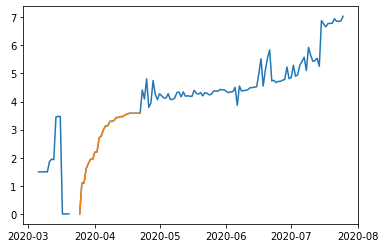

In [404]:
#Original dataseries without filling in missing values
x_original = pd.Series([datetime.strptime(str(d),"%Y%m%d") for d in state_df['date']],index=state_df.index)
y_original = np.log(state_df['hospitalized'])

#Dataset with missing values imputed 
state_df_imputed = data_clean_state.loc[data['state'] == "AK",:]
x_new = pd.Series([datetime.strptime(str(d),"%Y%m%d") for d in state_df_imputed['date']],index=state_df_imputed.index)
y_new = np.log(state_df_imputed['hospitalized'])

#Imputed series
plt.plot(x_new,y_new)
#New series
plt.plot(x_original,y_original)
plt.show()

We can clearly see that missing value imputation is incorrect for this time series. The trend clearly deviates from the original series and there are a lot of random fluctations. We should consider using a time series model to forecast this value independently or other methods of imputing the missing values.

date   2020-06-06
dtype: datetime64[ns]
date   2020-03-21
dtype: datetime64[ns]


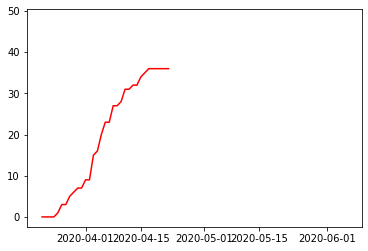

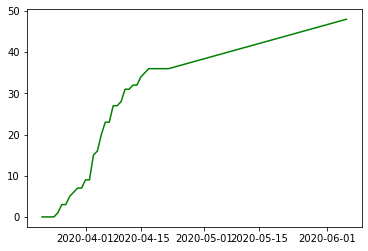

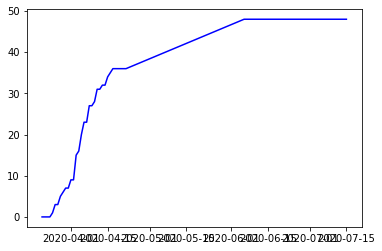

In [405]:
#Lets look at better ways of imupting the missing values
state_df['date'] = pd.Series([datetime.strptime(str(d),"%Y%m%d") for d in state_df['date']],index=state_df.index)
state_df = state_df[::-1]

print(state_df.loc[~state_df['hospitalized'].isna(),['date']].max())
print(state_df.loc[~state_df['hospitalized'].isna(),['date']].min())
hospitalized_interp = state_df['hospitalized'].interpolate(method="polynomial",order=1)
hospitalized_interp.index = state_df['date']
hospitalized_interp_bfilled = hospitalized_interp.fillna(method="bfill")
hospitalized_interp_bfilled.index = state_df['date']

#New series
plt.plot(state_df['date'],state_df['hospitalized'],color='red')
plt.show()
plt.plot(state_df['date'],hospitalized_interp,color='green')
plt.show()
plt.plot(state_df['date'],hospitalized_interp_bfilled,color='blue')
plt.show()

In [406]:
#Time series looks to have a clear trend and does not look stationary - let's confirm using the Augmented Dickey-Fuller test for unit root
print(sm.tsa.stattools.adfuller(hospitalized_interp.dropna()))
#Difference and test again
print(sm.tsa.stattools.adfuller(hospitalized_interp.diff().dropna()))
#Difference twice and test
print(sm.tsa.stattools.adfuller(hospitalized_interp.diff().diff().dropna()))

(0.16015043561775313, 0.9699358719017744, 4, 73, {'1%': -3.5232835753964475, '5%': -2.902030597326081, '10%': -2.5883710883843123}, 177.49282642773704)
(-2.303439702382243, 0.1708609988872477, 3, 73, {'1%': -3.5232835753964475, '5%': -2.902030597326081, '10%': -2.5883710883843123}, 173.91628060855382)
(-13.231611917970364, 9.559449581254892e-25, 1, 74, {'1%': -3.5219803175527606, '5%': -2.9014701097664504, '10%': -2.58807215485756}, 174.79384469257639)


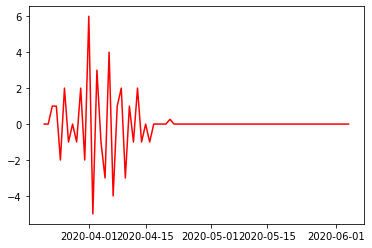

In [407]:
#Ok so twice differenced series is stationary according to test. Lets visually inspect and confirm
plt.plot(state_df['date'],hospitalized_interp.diff().diff(),color='red')
plt.show()

This clearly looks like 2 distinct series - not surprising because after 04/15 the series is interpolated.

In [408]:
#Lets repeat 
print(sm.tsa.stattools.adfuller(state_df['hospitalized'].dropna()))
#Difference and test again
print(sm.tsa.stattools.adfuller(state_df['hospitalized'].diff().dropna()))
#Difference twice and test
print(sm.tsa.stattools.adfuller(state_df['hospitalized'].diff().diff().dropna()))

(-0.592510597723103, 0.8726653604553036, 3, 30, {'1%': -3.6699197407407405, '5%': -2.9640707407407407, '10%': -2.621171111111111}, 87.82793161558646)
(-1.6287391044483166, 0.46815078514726577, 2, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 82.61479438709748)
(-8.020813727452099, 2.078773645072156e-12, 1, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 82.48112938162421)


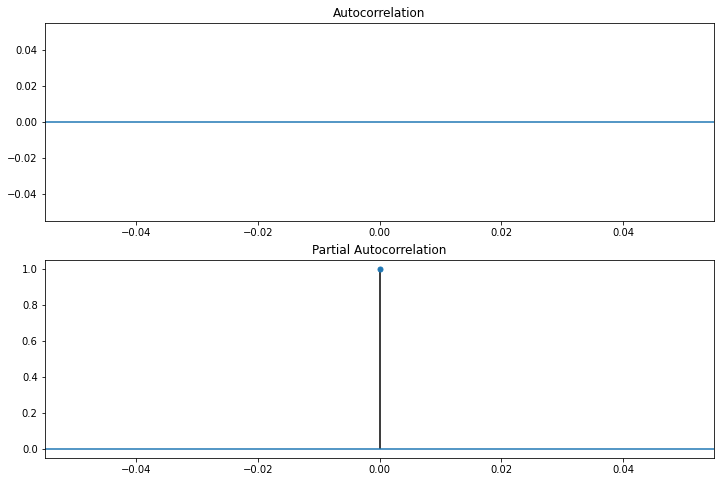

In [409]:
#ACF and PACF for interpolated series
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(hospitalized_interp.diff().diff(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hospitalized_interp.diff().diff(), lags=20, ax=ax2)
plt.show()

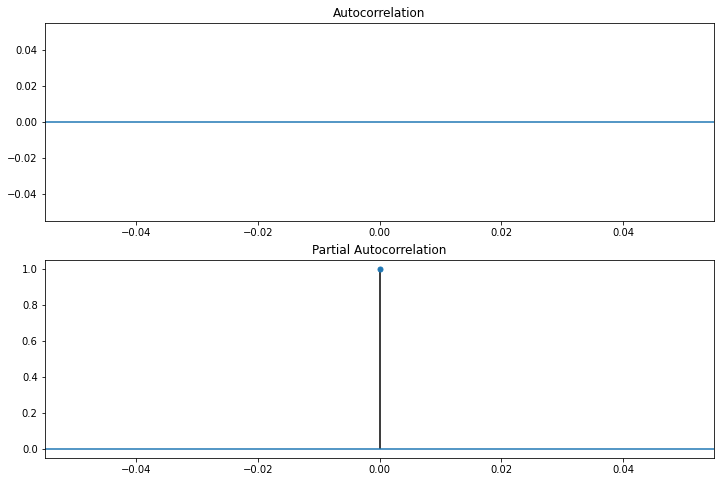

In [410]:
#ACF and PACF for original series
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(state_df['hospitalized'].diff().diff(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(state_df['hospitalized'].diff().diff(), lags=20, ax=ax2)
plt.show()

In [411]:
model=sm.tsa.ARIMA(hospitalized_interp[::-1].dropna(),order=(0,2,0))
results=model.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:        D2.hospitalized   No. Observations:                   76
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -134.693
Method:                           css   S.D. of innovations              1.424
Date:                Sun, 26 Jul 2020   AIC                            273.386
Time:                        21:09:00   BIC                            278.047
Sample:                    03-23-2020   HQIC                           275.249
                         - 06-06-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.163      0.021      0.983      -0.317       0.324


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


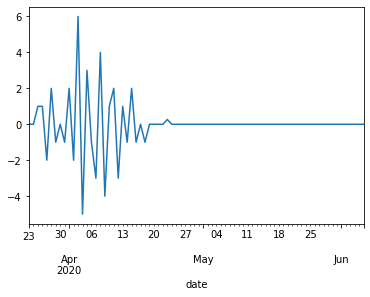

In [412]:
#Lets plot the residuals and check - should be normally distributed
results.resid.plot()
plt.show()

In [413]:
model2=sm.tsa.ARIMA(state_df['hospitalized'][::-1].dropna(),order=(0,2,0))
results2=model2.fit()
print(results2.summary())

                             ARIMA Model Results                              
Dep. Variable:        D2.hospitalized   No. Observations:                   32
Model:                 ARIMA(0, 2, 0)   Log Likelihood                 -80.864
Method:                           css   S.D. of innovations              3.029
Date:                Sun, 26 Jul 2020   AIC                            165.729
Time:                        21:09:05   BIC                            168.660
Sample:                             2   HQIC                           166.700
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3750      0.535      0.700      0.489      -0.674       1.424


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


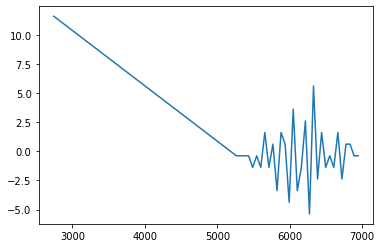

In [414]:
#Lets plot the residuals and check - should be normally distributed
results2.resid.plot()
plt.show()

In [415]:
#Get the days ahead to forecast
max_date = hospitalized_interp.index.max()
series_max_date = hospitalized_interp[~hospitalized_interp.isna()].index.max()
days_diff = np.abs(series_max_date - max_date).days
print(days_diff)

39


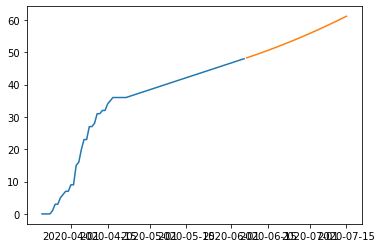

In [416]:
#Check forecast
forecast,std,conf=results.forecast(days_diff)
t = np.linspace(series_max_date.value, max_date.value, days_diff+1)
t = pd.to_datetime(t)
forecast_series = pd.Series(forecast, index=t[1:])

plt.plot(hospitalized_interp)
plt.plot(forecast_series)
plt.show()

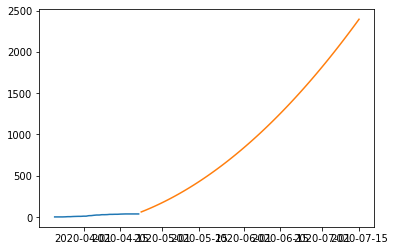

In [417]:
#Compare to using forecast for original series without any interpolation
hospitalized_orig = state_df['hospitalized']
hospitalized_orig.index = state_df['date']
max_date = hospitalized_orig.index.max()
hospitalized_orig = hospitalized_orig.dropna()[::-1]
hospitalized_orig = hospitalized_orig[0:-1]
series_max_date = hospitalized_orig[~hospitalized_orig.isna()].index.max()
days_diff = np.abs(series_max_date - max_date).days

#Check forecast
forecast2,std2,conf2=results2.forecast(days_diff)
t = np.linspace(series_max_date.value, max_date.value, days_diff+1)
t = pd.to_datetime(t)
forecast_series2 = pd.Series(forecast2, index=t[1:])

plt.plot(hospitalized_orig)
plt.plot(forecast_series2)
plt.show()

We can see this greatly overestimates the value of the series. It is much better to use the interpolated series to forecast as it contains more recent information, whereas using only the original series discards cuts off 2 months before the interpolated series!

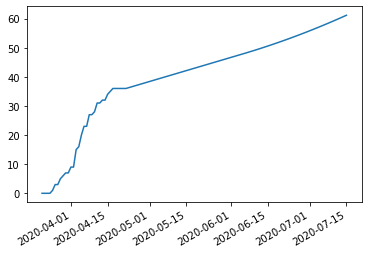

In [418]:
#Created full imputed series from interpolated series and forecast 
#Plot to check tht it looks smooth
hospitalized_imputed = hospitalized_interp.dropna().append(forecast_series)
hospitalized_imputed.plot()

In [735]:
def get_arima_d(**kwargs):
  
  series = kwargs.get('series')

  df_p_value = 1
  d = -1

  while(df_p_value > 0.05 and d < 2):
    d = d + 1
    for i in range(d):
      series = series.diff()
    df_p_value = sm.tsa.stattools.adfuller(series.dropna())[1]

  return(d)

In [425]:
#Check function returns correct value
print(get_arima_d(series=hospitalized_interp))
print(sm.tsa.stattools.adfuller(hospitalized_interp.dropna())[1])
print(sm.tsa.stattools.adfuller(hospitalized_interp.diff().dropna())[1])
print(sm.tsa.stattools.adfuller(hospitalized_interp.diff().diff().dropna())[1])

2
0.9699358719017744
0.1708609988872477
9.559449581254892e-25


In [653]:
def get_arima_pq(**kwargs):

  series = kwargs.get('series')
  d = kwargs.get('d')

  min_metric = np.inf
  best_i = 0
  best_j = 0

  for i in range(3):   

    for j in range(3):
      
      try:
        model=sm.tsa.ARIMA(series.dropna(),order=(i,d,j))
        results=model.fit()
        metric = results.aic
        converged = results.mle_retvals['converged']
        invalid_p = results.pvalues.isna().sum() 

        if (metric <= min_metric and invalid_p == 0 and converged):

          best_i = i
          best_j = j

      except ValueError as v:
        break

  return(best_i,best_j)

In [682]:
def get_arima_pq_exog(**kwargs):

  series = kwargs.get('series')
  exog_series = kwargs.get('exog_series')
  d = kwargs.get('d')

  min_metric = np.inf
  best_i = 0
  best_j = 0

  for i in range(3):   

    for j in range(3):
      
      try:
        model=sm.tsa.ARIMA(series.dropna(),exog=exog_series,order=(i,d,j))
        results=model.fit()
        metric = results.aic
        converged = results.mle_retvals['converged']
        invalid_p = results.pvalues.isna().sum() 

        if (metric <= min_metric and invalid_p == 0 and converged):

          best_i = i
          best_j = j

      except Exception as e:
        break

  return(best_i,best_j)

In [59]:
p,q = get_arima_pq(series=hospitalized_interp,d=2)
print(p,q)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/

3 3


In [426]:
model=sm.tsa.ARIMA(hospitalized_interp.dropna(),order=(3,2,3))
results=model.fit()
results.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D2.hospitalized   No. Observations:                   76
Model:                 ARIMA(3, 2, 3)   Log Likelihood                 -91.052
Method:                       css-mle   S.D. of innovations              0.792
Date:                Sun, 26 Jul 2020   AIC                            198.104
Time:                        21:14:11   BIC                            216.750
Sample:                    06-04-2020   HQIC                           205.556
                         - 03-21-2020                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0010      0.030     -0.032      0.974      -0.060       0.058
ar.L1.D2.hospitalized    -0.9959      0.385     -2.586      0.012      -1.751      -0.241
ar.L2.D2.hospitalized    -0.5499      0.528     -1.041      0.302      -1.585       0.486
ar.L3.D2.hospitalized     0.1066      0.302      0.353      0.725      -0.486       0.699
ma.L1.D2.hospitalized    -0.0004      0.370     -0.001      0.999      -0.726       0.725
ma.L2.D2.hospitalized     0.2378      0.192      1.240      0.219      -0.138       0.614
ma.L3.D2.hospitalized    -0.4586      0.140     -3.267      0.002      -0.734      -0.183
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7951           -0.8704j            1.1789           -0.3678
AR.2           -0.7951           +0.8704j            1.1789            0.3678
AR.3            6.7463           -0.0000j            6.7463           -0.0000
MA.1           -0.4879           -1.1051j            1.2080           -0.3162
MA.2           -0.4879           +1.1051j            1.2080            0.3162
MA.3            1.4945           -0.0000j            1.4945           -0.0000
-----------------------------------------------------------------------------
"""

In [599]:
def get_arima_pdq(**kwargs):
  
  series = kwargs.get('series')

  d = get_arima_d(series=series)
  p,q = get_arima_pq(series=series,d=d)


  return(p,d,q)

In [780]:
def impute_predict_full_ts(**kwargs):

  series = kwargs.get('series')

  #Check if missing values 
  if (series[~series.isna()].index.max() == series.index.max()):
     return (series)

  #Linear Interpolation of missing values
  series_interp = series.interpolate(method="polynomial",order=1)

  #Check if missing values 
  if (series_interp[~series_interp.isna()].index.max() == series_interp.index.max()):
     return (series_interp)

  #Calculate best ARIMA model parameters
  p,d,q = get_arima_pdq(series=series)

  model=sm.tsa.ARIMA(series_interp[::-1].dropna(),order=(1,d,1))
  results=model.fit()

  #Get the days ahead to forecast
  max_date = series_interp.index.max()
  series_max_date = series_interp[~series_interp.isna()].index.max()
  days_diff = np.abs(series_max_date - max_date).days

  forecast,std,conf=results.forecast(days_diff)
  t = np.linspace(series_max_date.value, max_date.value, days_diff+1)
  t = pd.to_datetime(t)
  forecast_series = pd.Series(forecast, index=t[1:])

  #Combine with original series to form full imputed series
  series_imputed = series_interp.dropna().append(forecast_series)

  return (series_imputed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

                             ARIMA Model Results                              
Dep. Variable:        D2.hospitalized   No. Observations:                   76
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -98.175
Method:                       css-mle   S.D. of innovations              0.874
Date:                Sun, 26 Jul 2020   AIC                            204.350
Time:                        21:54:37   BIC                            213.673
Sample:                    03-23-2020   HQIC                           208.076
                         - 06-06-2020                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0010      0.033      0.029      0.977      -0.064       0.066
ar.L1.D2.hospitalized    -0.5555      0.115     -4.836      0.000      -0.781      -0.330
ma.L1.D2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


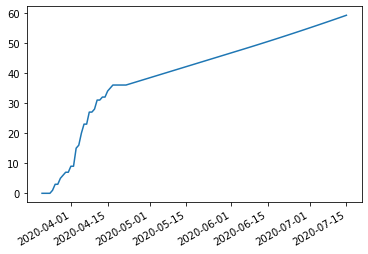

In [ ]:
hospitalized_to_impute = state_df['hospitalized']
hospitalized_to_impute.index = state_df['date']

full_imputed_series = impute_predict_full_ts(series=hospitalized_to_impute)
full_imputed_series.plot()

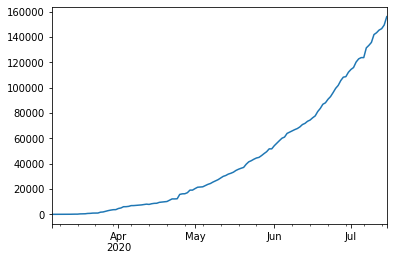

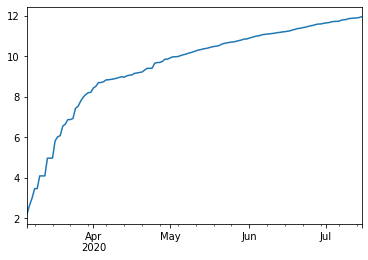

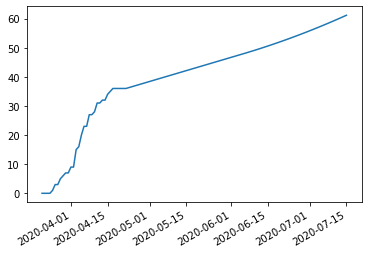

In [166]:
#Lets plot the number of cases for a single state - Arkansas
state_df = data.loc[data['state'] == "AK",:]
state_df = state_df.iloc[::-1]
state_df_testing = state_df.iloc[-10:,]
state_df = state_df.iloc[0:-10,]

time_index = pd.Series([datetime.strptime(str(d),"%Y%m%d") for d in state_df['date']],index=state_df.index)
y = state_df['total']
y.index = time_index
y_log = np.log(state_df['total'])
y_log.index = time_index

#Number of cases
# plot
y.plot()
plt.show()

#Log number of cases
# plot
y_log.plot()
plt.show()

#Number of hospitalizations
# plot
hospitalized_imputed.plot()
plt.show()

We can see that both time series are non-stationary. Advisable to use log-transformed series as we know the spread is exponential.

In [167]:
#Both time series look stationary - let's confirm using Dickey-Fuller test for unit root
print(sm.tsa.stattools.adfuller(y_log[::-1]))
print(sm.tsa.stattools.adfuller(y_log[::-1].diff().dropna()))
print(sm.tsa.stattools.adfuller(hospitalized_imputed))
print(sm.tsa.stattools.adfuller(hospitalized_imputed.diff().dropna()))

(1.7547997356596015, 0.9982550274166551, 11, 120, {'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}, -234.57668352945683)
(3.564622023628531, 1.0, 10, 120, {'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}, -229.9751610742253)
(-1.3103450525543945, 0.6244262498158043, 0, 116, {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}, 621.0046462190437)
(-10.40600715371702, 1.856111301868739e-18, 0, 115, {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}, 617.4085880557299)


In [168]:
hospital_cases_df = pd.DataFrame({'cases':y_log,'hospitalized':hospitalized_imputed})
hospital_cases_df['hospitalized'].fillna(0,inplace=True)
hospital_cases_df['hospitalized_diff'] = hospital_cases_df['hospitalized'].diff()
hospital_cases_df['cases_diff'] = hospital_cases_df['cases'].diff()
hospital_cases_df.head()

,cases,hospitalized,hospitalized_diff,cases_diff
2020-03-06,2.197225,0.0,NaN,NaN
2020-03-07,2.639057,0.0,0.0,0.441833
2020-03-08,2.995732,0.0,0.0,0.356675
2020-03-09,3.465736,0.0,0.0,0.470004
2020-03-10,3.465736,0.0,0.0,0.000000


In [169]:
print(sm.tsa.stattools.grangercausalitytests(hospital_cases_df[['hospitalized','cases']],1))
print(sm.tsa.stattools.grangercausalitytests(hospital_cases_df[['cases','hospitalized']],1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.0316 , p=0.0000  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=24.5948 , p=0.0000  , df=1
likelihood ratio test: chi2=22.5396 , p=0.0000  , df=1
parameter F test:         F=24.0316 , p=0.0000  , df_denom=128, df_num=1
{1: ({'ssr_ftest': (24.031607388233255, 2.814819883762798e-06, 128.0, 1), 'ssr_chi2test': (24.594848186394973, 7.074060394267319e-07, 1), 'lrtest': (22.53962140355327, 2.058536620234345e-06, 1), 'params_ftest': (24.031607388233695, 2.814819883762256e-06, 128.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fc79b8c5710>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fc79b8c4f98>, array([[0., 1., 0.]])])}

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0971  , p=0.2969  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=1.1228  , p=0.2893  , df=1
likelihood ratio test: chi2=1.1180  , p=0.2903  , d

In [170]:
gs = sm.tsa.stattools.grangercausalitytests(hospital_cases_df[['cases','hospitalized']],1)
gs[1][0]['lrtest'][1]
gs[1][0]['params_ftest'][1]
gs[1][0]['ssr_chi2test'][1]
gs[1][0]['ssr_ftest'][1]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0971  , p=0.2969  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=1.1228  , p=0.2893  , df=1
likelihood ratio test: chi2=1.1180  , p=0.2903  , df=1
parameter F test:         F=1.0971  , p=0.2969  , df_denom=128, df_num=1


0.29687344441566166

Strong evidence that hospitalizations are Granger caused by the number of cases and not vice-versa, as we know to be true!

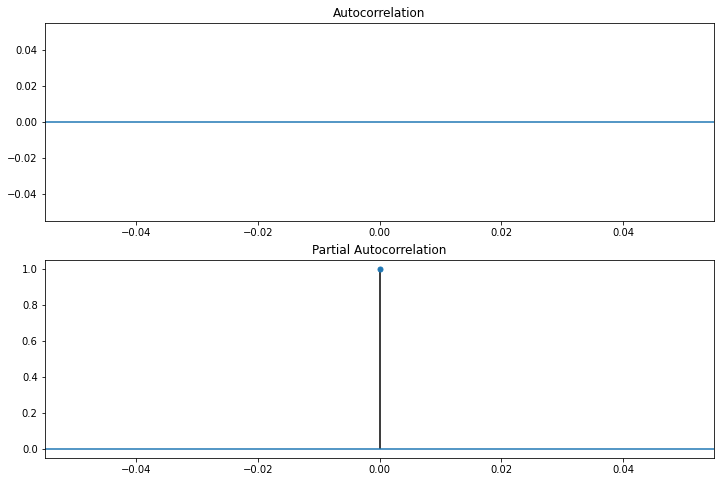

In [171]:
#ACF and PACF for number of cases
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_log.diff(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_log.diff(), lags=20, ax=ax2)
plt.show()

In [172]:
def check_arima_lag_bic(**kwargs):
  df = kwargs.get('df')
  shift = kwargs.get('shift')
  diff = kwargs.get('diff')
  endog = kwargs.get('endog')
  order = kwargs.get('order')

  df['lag']=df[diff].shift(shift)
  df = df.dropna()
  model=sm.tsa.ARIMA(endog=df[endog],exog=df['lag'],order=order)
  results=model.fit()
  val = results.aic
  return(val)

In [173]:
#Check function returns same value
arima_return = check_arima_lag_bic(df=hospital_cases_df
                                  ,shift=1
                                  ,diff='cases_diff'
                                  ,endog='hospitalized'
                                  ,order=[0,1,0])
print(arima_return)

hospital_cases_df['lag']=hospital_cases_df['cases_diff'].shift(1)
hospital_cases_df_check = hospital_cases_df.dropna()
model=sm.tsa.ARIMA(endog=hospital_cases_df_check['hospitalized'],exog=hospital_cases_df_check['lag'],order=[0,1,0])
results=model.fit()
print(results.summary())

323.6233521390145
                             ARIMA Model Results                              
Dep. Variable:         D.hospitalized   No. Observations:                  129
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -158.812
Method:                           css   S.D. of innovations              0.829
Date:                Sun, 26 Jul 2020   AIC                            323.623
Time:                        18:20:28   BIC                            332.203
Sample:                    03-09-2020   HQIC                           327.109
                         - 07-15-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4889      0.082      5.969      0.000       0.328       0.649
lag           -0.2083      0.517     -0.403      0.688      -1.223       0.806


In [174]:
#Grid search to find best lag for causal variable
best_i = 0
best_val = np.inf

for i in range(16):
  curr_val = check_arima_lag_bic(df=hospital_cases_df
                                ,shift=i
                                ,diff='cases_diff'
                                ,endog='hospitalized'
                                ,order=[0,1,0])
  print(curr_val)
  if(curr_val <= best_val):
    best_val = curr_val
    best_i = i

print(best_i)

325.5711104979697
323.6233521390145
321.9887928924583
320.15322440219455
318.36772016556364
316.1968218608597
314.68513121232
311.1446302006846
309.5648740844477
298.1890806264446
306.6919035258929
301.4494432588645
289.2395752918467
301.4717907005738
276.21866920766445
291.7547386163341
14


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [668]:
def get_best_lag(**kwargs):

  df = kwargs.get('df')
  max_lags = kwargs.get('max_lags')
  diff = kwargs.get('diff')
  endog = kwargs.get('endog')
  exog = kwargs.get('exog')
  order = kwargs.get('order')

  #Grid search to find best lag for causal variable
  best_i = 1
  best_val = np.inf

  for i in range(max_lags):
    i = i + 1

    try:
      curr_val = check_arima_lag_bic(df=df
                                    ,shift=i
                                    ,diff=diff
                                    ,endog=endog
                                    ,order=order)
      
      gs_sta = sm.tsa.stattools.grangercausalitytests(df[[endog,exog]],i)
      m1 = gs_sta[1][0]['lrtest'][1]
      m2 = gs_sta[1][0]['params_ftest'][1]
      m3 = gs_sta[1][0]['ssr_chi2test'][1]
      m4 = gs_sta[1][0]['ssr_ftest'][1]
      m_sum = m1 + m2 + m3 + m4 

      if (curr_val <= best_val and m_sum <= 0.2):
        best_val = curr_val
        best_i = i

    except Exception as e:
      #Model not converging
      break

  return(best_i)

In [352]:
get_best_lag(df=hospital_cases_df
            ,max_lags=16
            ,diff='cases_diff'
            ,endog='hospitalized'
            ,exog='cases'
            ,order=[0,1,0])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.0316 , p=0.0000  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=24.5948 , p=0.0000  , df=1
likelihood ratio test: chi2=22.5396 , p=0.0000  , df=1
parameter F test:         F=24.0316 , p=0.0000  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.0316 , p=0.0000  , df_denom=128, df_num=1
ssr based chi2 test:   chi2=24.5948 , p=0.0000  , df=1
likelihood ratio test: chi2=22.5396 , p=0.0000  , df=1
parameter F test:         F=24.0316 , p=0.0000  , df_denom=128, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.6053 , p=0.0000  , df_denom=125, df_num=2
ssr based chi2 test:   chi2=24.1391 , p=0.0000  , df=2
likelihood ratio test: chi2=22.1417 , p=0.0000  , df=2
parameter F test:         F=11.6053 , p=0.0000  , df_denom=125, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.0316 , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ssr based F test:         F=4.4520  , p=0.0053  , df_denom=122, df_num=3
ssr based chi2 test:   chi2=14.1224 , p=0.0027  , df=3
likelihood ratio test: chi2=13.4015 , p=0.0038  , df=3
parameter F test:         F=4.4520  , p=0.0053  , df_denom=122, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5575  , p=0.0089  , df_denom=119, df_num=4
ssr based chi2 test:   chi2=15.3064 , p=0.0041  , df=4
likelihood ratio test: chi2=14.4582 , p=0.0060  , df=4
parameter F test:         F=3.5575  , p=0.0089  , df_denom=119, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4758  , p=0.0058  , df_denom=116, df_num=5
ssr based chi2 test:   chi2=19.0272 , p=0.0019  , df=5
likelihood ratio test: chi2=17.7299 , p=0.0033  , df=5
parameter F test:         F=3.4758  , p=0.0058  , df_denom=116, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.2140  , p=0.0060  , df_denom=113, df_num=6
ssr based chi2 test: 

14

Can see that 14 days appears to be best lag. Again this concides with our knowledge of the time lag between people testing positve and being hospitalized.

In [177]:
#Get final model results for number of hospitalizations
hospital_cases_df['lag']=hospital_cases_df['cases_diff'].shift(14)
hospital_cases_df_final = hospital_cases_df.dropna()
model_hospital_cases=sm.tsa.ARIMA(endog=hospital_cases_df_final['hospitalized'],exog=hospital_cases_df_final['lag'],order=[0,1,0])
results_hospital_cases=model_hospital_cases.fit()
results_hospital_cases.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.hospitalized   No. Observations:                  116
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -135.109
Method:                           css   S.D. of innovations              0.776
Date:                Sun, 26 Jul 2020   AIC                            276.219
Time:                        18:21:15   BIC                            284.479
Sample:                    03-22-2020   HQIC                           279.572
                         - 07-15-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3334      0.081      4.096      0.000       0.174       0.493
lag            2.4940      0.488      5.108      0.000       1.537       3.451
==============================================================================
"""

In [337]:
#Get final model results for number of cases
cases_model=sm.tsa.ARIMA(endog=hospital_cases_df['cases'],order=[0,1,0])
results_cases=cases_model.fit()
results_cases.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.cases   No. Observations:                  131
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  68.347
Method:                           css   S.D. of innovations              0.144
Date:                Sun, 26 Jul 2020   AIC                           -132.694
Time:                        19:47:09   BIC                           -126.944
Sample:                    03-07-2020   HQIC                          -130.357
                         - 07-15-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0745      0.013      5.939      0.000       0.050       0.099
==============================================================================
"""

In [341]:
days_ahead = 14
forecast_cases,std_cases,conf_cases = results_cases.forecast(days_ahead)
forecast_hospitalizations,std_hospitalizations,conf_hospitalizations = results_hospital_cases.forecast(days_ahead,exog=forecast_cases)

In [344]:
forecast_cases

array([12.03271858, 12.10722989, 12.18174121, 12.25625252, 12.33076384,
       12.40527516, 12.47978647, 12.55429779, 12.6288091 , 12.70332042,
       12.77783173, 12.85234305, 12.92685436, 13.00136568])

In [345]:
forecast_hospitalizations

array([ 66.08627341,  71.06384796,  76.08708051,  81.13733071,
        86.22109649,  91.34205347,  96.48946742, 101.67144055,
       106.8848861 , 112.12633874, 117.40090954, 122.70424807,
       128.03689501, 133.40061696])

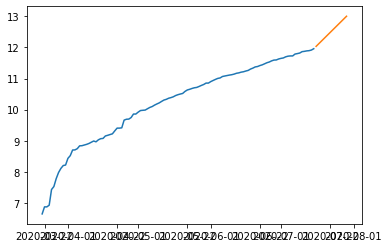

In [342]:
series_max_date = hospital_cases_df_final['cases'].index.max()
max_date = series_max_date + timedelta(days=days_ahead)
days_diff = np.abs(series_max_date - max_date).days

t = np.linspace(series_max_date.value, max_date.value, days_diff+1)
t = pd.to_datetime(t)
forecast_series = pd.Series(forecast_cases, index=t[1:])

plt.plot(hospital_cases_df_final['cases'])
plt.plot(forecast_series)
plt.show()

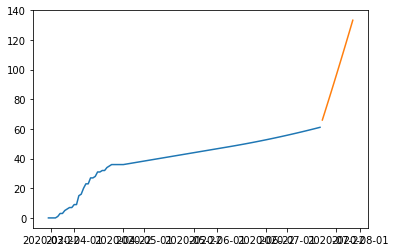

In [343]:
series_max_date = hospital_cases_df_final['hospitalized'].index.max()
max_date = series_max_date + timedelta(days=days_ahead)
days_diff = np.abs(series_max_date - max_date).days

t = np.linspace(series_max_date.value, max_date.value, days_diff+1)
t = pd.to_datetime(t)
forecast_series = pd.Series(forecast_hospitalizations, index=t[1:])

plt.plot(hospital_cases_df_final['hospitalized'])
plt.plot(forecast_series)
plt.show()

In [803]:
def get_arimax_forecast(**kwargs):

  endog_series = kwargs.get('endog_series')
  exog_series = kwargs.get('exog_series')
  days_ahead = kwargs.get('days_ahead')
  
  #Impute endogenous series
  endog_series = impute_predict_full_ts(series=endog_series)

  #Log and get best differencing value
  d = get_arima_d(series=exog_series)
  
  #Copy endogenous series for differencing
  exog_series_diff = exog_series.copy()
  
  #Diff number of cases series
  for i in range(d):
    i = i + 1
    exog_series_diff = exog_series_diff.diff()
  
  #Get best Arima parameters for exog
  p,d,q = get_arima_pdq(series=exog_series)

  #Create dataframe out of both series
  df = pd.DataFrame({'endog':endog_series,'exog':exog_series,'diff':exog_series_diff})
  df = df.dropna()

  #Get best lag
  best_lag = get_best_lag(df=df
                          ,max_lags=16
                          ,diff='diff'
                          ,endog='endog'
                          ,exog='exog'
                          ,order=[p,d,q])
  
  #Exogenous series ts model
  try:
    model_exog=sm.tsa.ARIMA(endog=df['exog'],order=[p,d,q])
    results_exog=model_exog.fit()
  except ValueError as v:
    model_exog=sm.tsa.ARIMA(endog=df['exog'],order=[p-1,d,q-1])
    results_exog=model_exog.fit()

  #Endogenous series ts model
  df['lag']=df['diff'].shift(best_lag)
  df_final=df[~df['lag'].isna()][::-1]

  #Get best Arima parameters for endog and fit
  p2,q2 = get_arima_pq_exog(series=df_final['endog'],series_exog=df_final['lag'],d=d)

  try:
    model_endog=sm.tsa.ARIMA(endog=df_final['endog'],exog=df_final['lag'],order=[p2,d,q2])
    results_endog=model_endog.fit()
  except Exception as e:
    model_endog=sm.tsa.ARIMA(endog=df_final['endog'],exog=df_final['lag'],order=[p2-1,d,q2-1])
    results_endog=model_endog.fit()

  #Forecast for n days ahead
  forecast_exog,std_exog,conf_exog = results_exog.forecast(days_ahead)
  forecast_endog,std_endog,conf_endog = results_endog.forecast(days_ahead,exog=forecast_exog)

  return(forecast_exog,forecast_endog)

In [804]:
#Lets plot the number of cases for a single state - Arkansas
state_df = data.loc[data['state'] == "AK",:]
#state_df = state_df.iloc[::-1]
#state_df_testing = state_df.iloc[-10:,]
#state_df = state_df.iloc[0:-10,]
#state_df = state_df[::-1]
state_df['date'] = pd.Series([datetime.strptime(str(d),"%Y%m%d") for d in state_df['date']],index=state_df.index)
state_df.index = state_df['date']

endog = state_df['hospitalized']
exog = np.log(state_df['total'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [782]:
cases_forecast,hospitalizations_forecast = get_arimax_forecast(endog_series=endog,exog_series=exog,days_ahead=14)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1824  , p=0.0030  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=9.4101  , p=0.0022  , df=1
likelihood ratio test: chi2=9.0701  , p=0.0026  , df=1
parameter F test:         F=9.1824  , p=0.0030  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1824  , p=0.0030  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=9.4101  , p=0.0022  , df=1
likelihood ratio test: chi2=9.0701  , p=0.0026  , df=1
parameter F test:         F=9.1824  , p=0.0030  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7130  , p=0.0043  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=11.9101 , p=0.0026  , df=2
likelihood ratio test: chi2=11.3682 , p=0.0034  , df=2
parameter F test:         F=5.7130  , p=0.0043  , df_denom=118, df_num=2


In [805]:
print(endog[0])
print(np.exp(exog[0]))
print(np.exp(cases_forecast))
print(hospitalizations_forecast)

nan
205065.99999999994
[35274.76503238 28044.30206237 21254.72355702 15553.5311786
 11828.88366938  9340.49821846  7113.13073592  5168.11352062
  3850.20143951  3007.41503139  2299.88692975  1665.69888021
  1217.07328032   936.85881654]
[  -5820.43416842  -19555.22177919  -39500.07836528  -65460.39081407
  -97265.70339064 -134768.9904128  -177800.69290503 -226161.99414172
 -279669.67174077 -338169.96658744 -401495.93971624 -469446.79763731
 -541827.23602787 -618474.39221884]


In [951]:
def get_state_forecast(**kwargs):

  state = kwargs.get("state")
  days_ahead = kwargs.get("days_ahead")
  endog= kwargs.get("endog")
  exog = kwargs.get("exog")
  log_exog = kwargs.get("log_exog")

  #Lets plot the number of cases for a single state - Arkansas
  state_df = data.loc[data['state'] == state,:]

  #state_df = state_df.iloc[::-1]
  #state_df_testing = state_df.iloc[-10:,]
  #state_df = state_df.iloc[0:-10,]
  #state_df = state_df[::-1]

  state_df['date'] = pd.Series([datetime.strptime(str(d),"%Y%m%d") for d in state_df['date']],index=state_df.index)
  state_df.index = state_df['date']

  endog = state_df[endog]

  if ('log_exog' in kwargs and log_exog):
    exog = np.log(state_df[exog])
  else:
    exog = state_df[exog]

  cases_forecast,hospitalizations_forecast = get_arimax_forecast(endog_series=endog,exog_series=exog,days_ahead=days_ahead)


  if (cases_forecast[len(cases_forecast)-1] > exog[0]):
    index = np.where(cases_forecast > exog[0])[0][0]

  if (cases_forecast[len(cases_forecast)-1] < exog[0]):
    index = np.where(cases_forecast < exog[0])[0][0]

  y1 = [cases_forecast[index],cases_forecast[index]+(cases_forecast[index+1]-cases_forecast[index])/5,cases_forecast[index]+(cases_forecast[index+1]-cases_forecast[index])/5 + (cases_forecast[index]+(cases_forecast[index+1]-cases_forecast[index])/5 - cases_forecast[index+2])/10]
  x1 = [0,1,2]
  x1_new = np.linspace(3,14,12)
  
  y2 = [hospitalizations_forecast[index],hospitalizations_forecast[index] + (hospitalizations_forecast[index+1]-hospitalizations_forecast[index])/5,hospitalizations_forecast[index] + (hospitalizations_forecast[index+1]-hospitalizations_forecast[index])/5 + (hospitalizations_forecast[index+2] - hospitalizations_forecast[index] + (hospitalizations_forecast[index+1]-hospitalizations_forecast[index])/5)/10]
  x2 = [0,1,2]
  x2_new = np.linspace(3,14,12)

  z1 = np.polyfit(x1, y1, 2)
  f1 = np.poly1d(z1)
  cases_forecast_new = np.concatenate([np.array(y1),f1(x1_new)])

  z2 = np.polyfit(x2, y2, 2)
  f2 = np.poly1d(z2)
  hospitalizations_forecast_new = np.concatenate([np.array(y2),f2(x2_new)])

  return(cases_forecast,hospitalizations_forecast,cases_forecast_new,hospitalizations_forecast_new)

In [972]:
cs,hs,cs2,hs2 = get_state_forecast(state='AK',days_ahead=14,endog='hospitalized',exog='positive',log_exog=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has be


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4703  , p=0.1186  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.5311  , p=0.1116  , df=1
likelihood ratio test: chi2=2.5058  , p=0.1134  , df=1
parameter F test:         F=2.4703  , p=0.1186  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4703  , p=0.1186  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.5311  , p=0.1116  , df=1
likelihood ratio test: chi2=2.5058  , p=0.1134  , df=1
parameter F test:         F=2.4703  , p=0.1186  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7424  , p=0.1795  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=3.6312  , p=0.1627  , df=2
likelihood ratio test: chi2=3.5791  , p=0.1670  , df=2
parameter F test:         F=1.7424  , p=0.1795  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4703  , p=0.1186  

In [973]:
cs,hs,cs2,hs2

(array([2774.90962449, 2794.85750928, 2810.98337146, 2825.44811553,
        2839.63757744, 2854.35788305, 2870.0056677 , 2886.70638894,
        2904.42027434, 2923.01903266, 2942.33814149, 2962.2099659 ,
        2982.48266067, 3003.02912099]),
 array([-0.25819231, -0.08258221, -0.2621066 , -0.42943049, -0.70202909,
        -1.00686082, -1.35513516, -1.72816756, -2.12301596, -2.53291185,
        -2.95463085, -3.38498253, -3.82188099, -4.26362898]),
 array([2870.0056677 , 2873.34581195, 2870.23836571, 2860.68332899,
        2844.68070177, 2822.23048407, 2793.33267589, 2757.98727721,
        2716.19428805, 2667.9537084 , 2613.26553827, 2552.12977765,
        2484.54642654, 2410.51548494, 2330.03695286]),
 array([-1.35513516, -1.42974164, -1.51399037, -1.60788135, -1.71141457,
        -1.82459004, -1.94740777, -2.07986774, -2.22196996, -2.37371443,
        -2.53510114, -2.70613011, -2.88680132, -3.07711478, -3.27707049]))

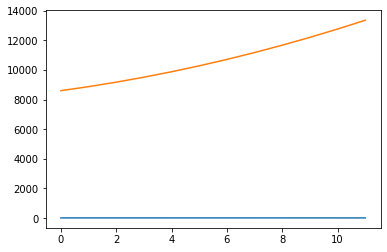

In [922]:
from scipy import interpolate

if (cases_forecast[len(cases_forecast)-1] > exog[0]):
  index = np.where(cases_forecast > exog[0])[0][0]

y1 = [cases_forecast[index],cases_forecast[index]+(cases_forecast[index+1]-cases_forecast[index])/5,cases_forecast[index]+(cases_forecast[index+1]-cases_forecast[index])/5 + (cases_forecast[index]+(cases_forecast[index+1]-cases_forecast[index])/5 - cases_forecast[index+2])/10]
x1 = [0,1,2]
x1_new = np.linspace(3,14,12)

y2 = [hospitalizations_forecast[index],hospitalizations_forecast[index] + (hospitalizations_forecast[index+1]-hospitalizations_forecast[index])/5,hospitalizations_forecast[index] + (hospitalizations_forecast[index+1]-hospitalizations_forecast[index])/5 + (hospitalizations_forecast[index+2] - hospitalizations_forecast[index] + (hospitalizations_forecast[index+1]-hospitalizations_forecast[index])/5)/10]
x2 = [0,1,2]
x2_new = np.linspace(3,14,12)

z1 = np.polyfit(x1, y1, 2)
f1 = np.poly1d(z1)
plt.plot(f(x1_new))

z2 = np.polyfit(x2, y2, 2)
f2 = np.poly1d(z2)
plt.plot(f2(x2_new))

plt.show()

In [975]:
all_states_pred_df = pd.DataFrame(columns=['state','cases_pred','hosp_pred'])
states_list = list(pd.unique(data['state']))
for state in states_list:
  try:
    cs,hs,cs2,hs2 = get_state_forecast(state=state,days_ahead=14,endog='hospitalized',exog='positive',log_exog=False)
    state_dict = {'state':state,'cases_pred':cs,'hosp_pred':hs}
  except:
    state_dict = {'state':[state],'cases_pred':[None],'hosp_pred':[None]}

  state_pred_df = pd.DataFrame(state_dict)
  all_states_pred_df = all_states_pred_df.append(state_pred_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has be


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4703  , p=0.1186  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.5311  , p=0.1116  , df=1
likelihood ratio test: chi2=2.5058  , p=0.1134  , df=1
parameter F test:         F=2.4703  , p=0.1186  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4703  , p=0.1186  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.5311  , p=0.1116  , df=1
likelihood ratio test: chi2=2.5058  , p=0.1134  , df=1
parameter F test:         F=2.4703  , p=0.1186  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7424  , p=0.1795  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=3.6312  , p=0.1627  , df=2
likelihood ratio test: chi2=3.5791  , p=0.1670  , df=2
parameter F test:         F=1.7424  , p=0.1795  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4703  , p=0.1186  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1
ssr based chi2 test:   chi2=1.2263  , p=0.2681  , df=1
likelihood ratio test: chi2=1.2196  , p=0.2694  , df=1
parameter F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1
ssr based chi2 test:   chi2=1.2263  , p=0.2681  , df=1
likelihood ratio test: chi2=1.2196  , p=0.2694  , df=1
parameter F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5738  , p=0.5651  , df_denom=105, df_num=2
ssr based chi2 test:   chi2=1.2023  , p=0.5482  , df=2
likelihood ratio test: chi2=1.1958  , p=0.5500  , df=2
parameter F test:         F=0.5738  , p=0.5651  , df_denom=105, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1
ssr based chi2 test:   chi2=1.2263  , p=0.2681  , df=1
likelihood ratio test: chi2=1.2196  , p=0.2694  , df=1
parameter F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5738  , p=0.5651  , df_denom=105, df_num=2
ssr based chi2 test:   chi2=1.2023  , p=0.5482  , df=2
likelihood ratio test: chi2=1.1958  , p=0.5500  , df=2
parameter F test:         F=0.5738  , p=0.5651  , df_denom=105, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1537  , p=0.9271  , df_denom=102, df_num=3
ssr based chi2 test:   chi2=0.4926  , p=0.9205  , df=3
likelihood ratio test: chi2=0.4915  , p=0.9208  , df=3
parameter F test:         F=0.1537  , p=0.9271  , df_denom=102, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1932  , p=0.2771  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1
ssr based chi2 test:   chi2=1.2263  , p=0.2681  , df=1
likelihood ratio test: chi2=1.2196  , p=0.2694  , df=1
parameter F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5738  , p=0.5651  , df_denom=105, df_num=2
ssr based chi2 test:   chi2=1.2023  , p=0.5482  , df=2
likelihood ratio test: chi2=1.1958  , p=0.5500  , df=2
parameter F test:         F=0.5738  , p=0.5651  , df_denom=105, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1537  , p=0.9271  , df_denom=102, df_num=3
ssr based chi2 test:   chi2=0.4926  , p=0.9205  , df=3
likelihood ratio test: chi2=0.4915  , p=0.9208  , df=3
parameter F test:         F=0.1537  , p=0.9271  , df_denom=102, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1800  , p=0.9483  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1
ssr based chi2 test:   chi2=1.2263  , p=0.2681  , df=1
likelihood ratio test: chi2=1.2196  , p=0.2694  , df=1
parameter F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5738  , p=0.5651  , df_denom=105, df_num=2
ssr based chi2 test:   chi2=1.2023  , p=0.5482  , df=2
likelihood ratio test: chi2=1.1958  , p=0.5500  , df=2
parameter F test:         F=0.5738  , p=0.5651  , df_denom=105, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1537  , p=0.9271  , df_denom=102, df_num=3
ssr based chi2 test:   chi2=0.4926  , p=0.9205  , df=3
likelihood ratio test: chi2=0.4915  , p=0.9208  , df=3
parameter F test:         F=0.1537  , p=0.9271  , df_denom=102, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1800  , p=0.9483  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5
ssr based F test:         F=0.1670  , p=0.9741  , df_denom=96, df_num=5
ssr based chi2 test:   chi2=0.9308  , p=0.9680  , df=5
likelihood ratio test: chi2=0.9267  , p=0.9683  , df=5
parameter F test:         F=0.1670  , p=0.9741  , df_denom=96, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.1662  , p=0.9851  , df_denom=93, df_num=6
ssr based chi2 test:   chi2=1.1365  , p=0.9799  , df=6
likelihood ratio test: chi2=1.1304  , p=0.9802  , df=6
parameter F test:         F=0.1662  , p=0.9851  , df_denom=93, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6264  , p=0.7329  , df_denom=90, df_num=7
ssr based chi2 test:   chi2=5.1157  , p=0.6458  , df=7
likelihood ratio test: chi2=4.9950  , p=0.6606  , df=7
parameter F test:         F=0.6264  , p=0.7329  , df_denom=90, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6482  , p=0.7351  , df_denom=87, df_num=8
ssr based chi2 test:   chi

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



parameter F test:         F=0.6482  , p=0.7351  , df_denom=87, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7874  , p=0.6286  , df_denom=84, df_num=9
ssr based chi2 test:   chi2=8.6890  , p=0.4665  , df=9
likelihood ratio test: chi2=8.3419  , p=0.5001  , df=9
parameter F test:         F=0.7874  , p=0.6286  , df_denom=84, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5972  , p=0.8118  , df_denom=81, df_num=10
ssr based chi2 test:   chi2=7.5199  , p=0.6756  , df=10
likelihood ratio test: chi2=7.2556  , p=0.7011  , df=10
parameter F test:         F=0.5972  , p=0.8118  , df_denom=81, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.7288  , p=0.7077  , df_denom=78, df_num=11
ssr based chi2 test:   chi2=10.3812 , p=0.4965  , df=11
likelihood ratio test: chi2=9.8816  , p=0.5411  , df=11
parameter F test:         F=0.7288  , p=0.7077  , df_denom=78, df_num=11

Granger Causalit

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1
ssr based chi2 test:   chi2=1.2263  , p=0.2681  , df=1
likelihood ratio test: chi2=1.2196  , p=0.2694  , df=1
parameter F test:         F=1.1932  , p=0.2771  , df_denom=108, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5738  , p=0.5651  , df_denom=105, df_num=2
ssr based chi2 test:   chi2=1.2023  , p=0.5482  , df=2
likelihood ratio test: chi2=1.1958  , p=0.5500  , df=2
parameter F test:         F=0.5738  , p=0.5651  , df_denom=105, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1537  , p=0.9271  , df_denom=102, df_num=3
ssr based chi2 test:   chi2=0.4926  , p=0.9205  , df=3
likelihood ratio test: chi2=0.4915  , p=0.9208  , df=3
parameter F test:         F=0.1537  , p=0.9271  , df_denom=102, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1800  , p=0.9483  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



parameter F test:         F=0.1537  , p=0.9271  , df_denom=102, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1800  , p=0.9483  , df_denom=99, df_num=4
ssr based chi2 test:   chi2=0.7854  , p=0.9404  , df=4
likelihood ratio test: chi2=0.7826  , p=0.9408  , df=4
parameter F test:         F=0.1800  , p=0.9483  , df_denom=99, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.1670  , p=0.9741  , df_denom=96, df_num=5
ssr based chi2 test:   chi2=0.9308  , p=0.9680  , df=5
likelihood ratio test: chi2=0.9267  , p=0.9683  , df=5
parameter F test:         F=0.1670  , p=0.9741  , df_denom=96, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.1662  , p=0.9851  , df_denom=93, df_num=6
ssr based chi2 test:   chi2=1.1365  , p=0.9799  , df=6
likelihood ratio test: chi2=1.1304  , p=0.9802  , df=6
parameter F test:         F=0.1662  , p=0.9851  , df_denom=93, df_num=6

Granger Causality
number 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ssr based F test:         F=0.1670  , p=0.9741  , df_denom=96, df_num=5
ssr based chi2 test:   chi2=0.9308  , p=0.9680  , df=5
likelihood ratio test: chi2=0.9267  , p=0.9683  , df=5
parameter F test:         F=0.1670  , p=0.9741  , df_denom=96, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.1662  , p=0.9851  , df_denom=93, df_num=6
ssr based chi2 test:   chi2=1.1365  , p=0.9799  , df=6
likelihood ratio test: chi2=1.1304  , p=0.9802  , df=6
parameter F test:         F=0.1662  , p=0.9851  , df_denom=93, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6264  , p=0.7329  , df_denom=90, df_num=7
ssr based chi2 test:   chi2=5.1157  , p=0.6458  , df=7
likelihood ratio test: chi2=4.9950  , p=0.6606  , df=7
parameter F test:         F=0.6264  , p=0.7329  , df_denom=90, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6482  , p=0.7351  , df_denom=87, df_num=8
ssr based chi2 test:   chi2=

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1
ssr based chi2 test:   chi2=23.2391 , p=0.0000  , df=1
likelihood ratio test: chi2=21.5333 , p=0.0000  , df=1
parameter F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1
ssr based chi2 test:   chi2=23.2391 , p=0.0000  , df=1
likelihood ratio test: chi2=21.5333 , p=0.0000  , df=1
parameter F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2
ssr based chi2 test:   chi2=8.8658  , p=0.0119  , df=2
likelihood ratio test: chi2=8.6000  , p=0.0136  , df=2
parameter F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7516 , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1
ssr based chi2 test:   chi2=23.2391 , p=0.0000  , df=1
likelihood ratio test: chi2=21.5333 , p=0.0000  , df=1
parameter F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2
ssr based chi2 test:   chi2=8.8658  , p=0.0119  , df=2
likelihood ratio test: chi2=8.6000  , p=0.0136  , df=2
parameter F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3
ssr based chi2 test:   chi2=19.3637 , p=0.0002  , df=3
likelihood ratio test: chi2=18.1445 , p=0.0004  , df=3
parameter F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.5797  , p=0.0004 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1
ssr based chi2 test:   chi2=23.2391 , p=0.0000  , df=1
likelihood ratio test: chi2=21.5333 , p=0.0000  , df=1
parameter F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2
ssr based chi2 test:   chi2=8.8658  , p=0.0119  , df=2
likelihood ratio test: chi2=8.6000  , p=0.0136  , df=2
parameter F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3
ssr based chi2 test:   chi2=19.3637 , p=0.0002  , df=3
likelihood ratio test: chi2=18.1445 , p=0.0004  , df=3
parameter F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.5797  , p=0.0004  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1
ssr based chi2 test:   chi2=23.2391 , p=0.0000  , df=1
likelihood ratio test: chi2=21.5333 , p=0.0000  , df=1
parameter F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2
ssr based chi2 test:   chi2=8.8658  , p=0.0119  , df=2
likelihood ratio test: chi2=8.6000  , p=0.0136  , df=2
parameter F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3
ssr based chi2 test:   chi2=19.3637 , p=0.0002  , df=3
likelihood ratio test: chi2=18.1445 , p=0.0004  , df=3
parameter F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.5797  , p=0.0004  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1
ssr based chi2 test:   chi2=23.2391 , p=0.0000  , df=1
likelihood ratio test: chi2=21.5333 , p=0.0000  , df=1
parameter F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2
ssr based chi2 test:   chi2=8.8658  , p=0.0119  , df=2
likelihood ratio test: chi2=8.6000  , p=0.0136  , df=2
parameter F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3
ssr based chi2 test:   chi2=19.3637 , p=0.0002  , df=3
likelihood ratio test: chi2=18.1445 , p=0.0004  , df=3
parameter F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.5797  , p=0.0004  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1
ssr based chi2 test:   chi2=23.2391 , p=0.0000  , df=1
likelihood ratio test: chi2=21.5333 , p=0.0000  , df=1
parameter F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2
ssr based chi2 test:   chi2=8.8658  , p=0.0119  , df=2
likelihood ratio test: chi2=8.6000  , p=0.0136  , df=2
parameter F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3
ssr based chi2 test:   chi2=19.3637 , p=0.0002  , df=3
likelihood ratio test: chi2=18.1445 , p=0.0004  , df=3
parameter F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.5797  , p=0.0004  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


ssr based F test:         F=3.8538  , p=0.0000  , df_denom=98, df_num=15
ssr based chi2 test:   chi2=76.0938 , p=0.0000  , df=15
likelihood ratio test: chi2=59.8115 , p=0.0000  , df=15
parameter F test:         F=3.8538  , p=0.0000  , df_denom=98, df_num=15

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1
ssr based chi2 test:   chi2=23.2391 , p=0.0000  , df=1
likelihood ratio test: chi2=21.5333 , p=0.0000  , df=1
parameter F test:         F=22.7516 , p=0.0000  , df_denom=140, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2
ssr based chi2 test:   chi2=8.8658  , p=0.0119  , df=2
likelihood ratio test: chi2=8.6000  , p=0.0136  , df=2
parameter F test:         F=4.2768  , p=0.0158  , df_denom=137, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1341  , p=0.0006  , df_denom=134, df_num=3
ssr based chi2 test

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1355  , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1355  , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1355  , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1355  , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1355  , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1355  , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1355  , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1355  , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1355  , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=4.7007  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6138  , p=0.0317  , df=1
parameter F test:         F=4.5870  , p=0.0342  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=6.4791  , p=0.0392  , df=2
likelihood ratio test: chi2=6.3142  , p=0.0425  , df=2
parameter F test:         F=3.1079  , p=0.0484  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=29.1707 , p=0.0000  , df=3
likelihood ratio test: chi2=26.1554 , p=0.0000  , df=3
parameter F test:         F=9.1657  , p=0.0000  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1355  , p=0.0000  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=50.6989 , p=0.0000  , df=1
likelihood ratio test: chi2=42.5572 , p=0.0000  , df=1
parameter F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=50.6989 , p=0.0000  , df=1
likelihood ratio test: chi2=42.5572 , p=0.0000  , df=1
parameter F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=25.5192 , p=0.0000  , df=2
likelihood ratio test: chi2=23.2058 , p=0.0000  , df=2
parameter F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=50.6989 , p=0.0000  , df=1
likelihood ratio test: chi2=42.5572 , p=0.0000  , df=1
parameter F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=25.5192 , p=0.0000  , df=2
likelihood ratio test: chi2=23.2058 , p=0.0000  , df=2
parameter F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=27.8187 , p=0.0000  , df=3
likelihood ratio test: chi2=25.0790 , p=0.0000  , df=3
parameter F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=50.6989 , p=0.0000  , df=1
likelihood ratio test: chi2=42.5572 , p=0.0000  , df=1
parameter F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=25.5192 , p=0.0000  , df=2
likelihood ratio test: chi2=23.2058 , p=0.0000  , df=2
parameter F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=27.8187 , p=0.0000  , df=3
likelihood ratio test: chi2=25.0790 , p=0.0000  , df=3
parameter F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3687  , p=0.0005  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=50.6989 , p=0.0000  , df=1
likelihood ratio test: chi2=42.5572 , p=0.0000  , df=1
parameter F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=25.5192 , p=0.0000  , df=2
likelihood ratio test: chi2=23.2058 , p=0.0000  , df=2
parameter F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=27.8187 , p=0.0000  , df=3
likelihood ratio test: chi2=25.0790 , p=0.0000  , df=3
parameter F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3687  , p=0.0005  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/pytho


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=50.6989 , p=0.0000  , df=1
likelihood ratio test: chi2=42.5572 , p=0.0000  , df=1
parameter F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=25.5192 , p=0.0000  , df=2
likelihood ratio test: chi2=23.2058 , p=0.0000  , df=2
parameter F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=27.8187 , p=0.0000  , df=3
likelihood ratio test: chi2=25.0790 , p=0.0000  , df=3
parameter F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3687  , p=0.0005  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=50.6989 , p=0.0000  , df=1
likelihood ratio test: chi2=42.5572 , p=0.0000  , df=1
parameter F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=25.5192 , p=0.0000  , df=2
likelihood ratio test: chi2=23.2058 , p=0.0000  , df=2
parameter F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=27.8187 , p=0.0000  , df=3
likelihood ratio test: chi2=25.0790 , p=0.0000  , df=3
parameter F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3687  , p=0.0005  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=50.6989 , p=0.0000  , df=1
likelihood ratio test: chi2=42.5572 , p=0.0000  , df=1
parameter F test:         F=49.4821 , p=0.0000  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=25.5192 , p=0.0000  , df=2
likelihood ratio test: chi2=23.2058 , p=0.0000  , df=2
parameter F test:         F=12.2451 , p=0.0000  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=27.8187 , p=0.0000  , df=3
likelihood ratio test: chi2=25.0790 , p=0.0000  , df=3
parameter F test:         F=8.7452  , p=0.0000  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3687  , p=0.0005  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/sta


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=30.7971 , p=0.0000  , df=1
likelihood ratio test: chi2=27.4372 , p=0.0000  , df=1
parameter F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=30.7971 , p=0.0000  , df=1
likelihood ratio test: chi2=27.4372 , p=0.0000  , df=1
parameter F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=15.0863 , p=0.0005  , df=2
likelihood ratio test: chi2=14.2106 , p=0.0008  , df=2
parameter F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=30.7971 , p=0.0000  , df=1
likelihood ratio test: chi2=27.4372 , p=0.0000  , df=1
parameter F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=15.0863 , p=0.0005  , df=2
likelihood ratio test: chi2=14.2106 , p=0.0008  , df=2
parameter F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=21.0957 , p=0.0001  , df=3
likelihood ratio test: chi2=19.4211 , p=0.0002  , df=3
parameter F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=30.7971 , p=0.0000  , df=1
likelihood ratio test: chi2=27.4372 , p=0.0000  , df=1
parameter F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=15.0863 , p=0.0005  , df=2
likelihood ratio test: chi2=14.2106 , p=0.0008  , df=2
parameter F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=21.0957 , p=0.0001  , df=3
likelihood ratio test: chi2=19.4211 , p=0.0002  , df=3
parameter F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5957  , p=0.0018  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=30.7971 , p=0.0000  , df=1
likelihood ratio test: chi2=27.4372 , p=0.0000  , df=1
parameter F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=15.0863 , p=0.0005  , df=2
likelihood ratio test: chi2=14.2106 , p=0.0008  , df=2
parameter F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=21.0957 , p=0.0001  , df=3
likelihood ratio test: chi2=19.4211 , p=0.0002  , df=3
parameter F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5957  , p=0.0018  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=30.7971 , p=0.0000  , df=1
likelihood ratio test: chi2=27.4372 , p=0.0000  , df=1
parameter F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=15.0863 , p=0.0005  , df=2
likelihood ratio test: chi2=14.2106 , p=0.0008  , df=2
parameter F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=21.0957 , p=0.0001  , df=3
likelihood ratio test: chi2=19.4211 , p=0.0002  , df=3
parameter F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5957  , p=0.0018  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=30.7971 , p=0.0000  , df=1
likelihood ratio test: chi2=27.4372 , p=0.0000  , df=1
parameter F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=15.0863 , p=0.0005  , df=2
likelihood ratio test: chi2=14.2106 , p=0.0008  , df=2
parameter F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=21.0957 , p=0.0001  , df=3
likelihood ratio test: chi2=19.4211 , p=0.0002  , df=3
parameter F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5957  , p=0.0018  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=30.7971 , p=0.0000  , df=1
likelihood ratio test: chi2=27.4372 , p=0.0000  , df=1
parameter F test:         F=30.0335 , p=0.0000  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=15.0863 , p=0.0005  , df=2
likelihood ratio test: chi2=14.2106 , p=0.0008  , df=2
parameter F test:         F=7.2288  , p=0.0011  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=21.0957 , p=0.0001  , df=3
likelihood ratio test: chi2=19.4211 , p=0.0002  , df=3
parameter F test:         F=6.6183  , p=0.0004  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5957  , p=0.0018  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.9343  , p=0.0148  , df=1
likelihood ratio test: chi2=5.7933  , p=0.0161  , df=1
parameter F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.9343  , p=0.0148  , df=1
likelihood ratio test: chi2=5.7933  , p=0.0161  , df=1
parameter F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.2151  , p=0.0271  , df=2
likelihood ratio test: chi2=7.0065  , p=0.0301  , df=2
parameter F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.9343  , p=0.0148  , df=1
likelihood ratio test: chi2=5.7933  , p=0.0161  , df=1
parameter F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.2151  , p=0.0271  , df=2
likelihood ratio test: chi2=7.0065  , p=0.0301  , df=2
parameter F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=6.5330  , p=0.0884  , df=3
likelihood ratio test: chi2=6.3600  , p=0.0954  , df=3
parameter F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7871  , p=0.0177  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.9343  , p=0.0148  , df=1
likelihood ratio test: chi2=5.7933  , p=0.0161  , df=1
parameter F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.2151  , p=0.0271  , df=2
likelihood ratio test: chi2=7.0065  , p=0.0301  , df=2
parameter F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=6.5330  , p=0.0884  , df=3
likelihood ratio test: chi2=6.3600  , p=0.0954  , df=3
parameter F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9329  , p=0.1101  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.9343  , p=0.0148  , df=1
likelihood ratio test: chi2=5.7933  , p=0.0161  , df=1
parameter F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.2151  , p=0.0271  , df=2
likelihood ratio test: chi2=7.0065  , p=0.0301  , df=2
parameter F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=6.5330  , p=0.0884  , df=3
likelihood ratio test: chi2=6.3600  , p=0.0954  , df=3
parameter F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9329  , p=0.1101  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.9343  , p=0.0148  , df=1
likelihood ratio test: chi2=5.7933  , p=0.0161  , df=1
parameter F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.2151  , p=0.0271  , df=2
likelihood ratio test: chi2=7.0065  , p=0.0301  , df=2
parameter F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=6.5330  , p=0.0884  , df=3
likelihood ratio test: chi2=6.3600  , p=0.0954  , df=3
parameter F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9329  , p=0.1101  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.9343  , p=0.0148  , df=1
likelihood ratio test: chi2=5.7933  , p=0.0161  , df=1
parameter F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.2151  , p=0.0271  , df=2
likelihood ratio test: chi2=7.0065  , p=0.0301  , df=2
parameter F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=6.5330  , p=0.0884  , df=3
likelihood ratio test: chi2=6.3600  , p=0.0954  , df=3
parameter F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9329  , p=0.1101  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dis


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.9343  , p=0.0148  , df=1
likelihood ratio test: chi2=5.7933  , p=0.0161  , df=1
parameter F test:         F=5.7871  , p=0.0177  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.2151  , p=0.0271  , df=2
likelihood ratio test: chi2=7.0065  , p=0.0301  , df=2
parameter F test:         F=3.4572  , p=0.0348  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=6.5330  , p=0.0884  , df=3
likelihood ratio test: chi2=6.3600  , p=0.0954  , df=3
parameter F test:         F=2.0496  , p=0.1110  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9329  , p=0.1101  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9344  , p=0.0508  , df_denom=78, df_num=1
ssr based chi2 test:   chi2=4.0857  , p=0.0432  , df=1
likelihood ratio test: chi2=3.9860  , p=0.0459  , df=1
parameter F test:         F=3.9344  , p=0.0508  , df_denom=78, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=5.1657  , p=0.0230  , df=1
likelihood ratio test: chi2=5.0558  , p=0.0245  , df=1
parameter F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=5.1657  , p=0.0230  , df=1
likelihood ratio test: chi2=5.0558  , p=0.0245  , df=1
parameter F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2
ssr based chi2 test:   chi2=23.0969 , p=0.0000  , df=2
likelihood ratio test: chi2=21.0788 , p=0.0000  , df=2
parameter F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=5.1657  , p=0.0230  , df=1
likelihood ratio test: chi2=5.0558  , p=0.0245  , df=1
parameter F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2
ssr based chi2 test:   chi2=23.0969 , p=0.0000  , df=2
likelihood ratio test: chi2=21.0788 , p=0.0000  , df=2
parameter F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3
ssr based chi2 test:   chi2=23.2875 , p=0.0000  , df=3
likelihood ratio test: chi2=21.2222 , p=0.0001  , df=3
parameter F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=5.1657  , p=0.0230  , df=1
likelihood ratio test: chi2=5.0558  , p=0.0245  , df=1
parameter F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2
ssr based chi2 test:   chi2=23.0969 , p=0.0000  , df=2
likelihood ratio test: chi2=21.0788 , p=0.0000  , df=2
parameter F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3
ssr based chi2 test:   chi2=23.2875 , p=0.0000  , df=3
likelihood ratio test: chi2=21.2222 , p=0.0001  , df=3
parameter F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3479  , p=0.0006  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=5.1657  , p=0.0230  , df=1
likelihood ratio test: chi2=5.0558  , p=0.0245  , df=1
parameter F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2
ssr based chi2 test:   chi2=23.0969 , p=0.0000  , df=2
likelihood ratio test: chi2=21.0788 , p=0.0000  , df=2
parameter F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3
ssr based chi2 test:   chi2=23.2875 , p=0.0000  , df=3
likelihood ratio test: chi2=21.2222 , p=0.0001  , df=3
parameter F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3479  , p=0.0006  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=5.1657  , p=0.0230  , df=1
likelihood ratio test: chi2=5.0558  , p=0.0245  , df=1
parameter F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2
ssr based chi2 test:   chi2=23.0969 , p=0.0000  , df=2
likelihood ratio test: chi2=21.0788 , p=0.0000  , df=2
parameter F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3
ssr based chi2 test:   chi2=23.2875 , p=0.0000  , df=3
likelihood ratio test: chi2=21.2222 , p=0.0001  , df=3
parameter F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3479  , p=0.0006  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=5.1657  , p=0.0230  , df=1
likelihood ratio test: chi2=5.0558  , p=0.0245  , df=1
parameter F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2
ssr based chi2 test:   chi2=23.0969 , p=0.0000  , df=2
likelihood ratio test: chi2=21.0788 , p=0.0000  , df=2
parameter F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3
ssr based chi2 test:   chi2=23.2875 , p=0.0000  , df=3
likelihood ratio test: chi2=21.2222 , p=0.0001  , df=3
parameter F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3479  , p=0.0006  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1
ssr based chi2 test:   chi2=5.1657  , p=0.0230  , df=1
likelihood ratio test: chi2=5.0558  , p=0.0245  , df=1
parameter F test:         F=5.0344  , p=0.0268  , df_denom=115, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2
ssr based chi2 test:   chi2=23.0969 , p=0.0000  , df=2
likelihood ratio test: chi2=21.0788 , p=0.0000  , df=2
parameter F test:         F=11.0549 , p=0.0000  , df_denom=112, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3
ssr based chi2 test:   chi2=23.2875 , p=0.0000  , df=3
likelihood ratio test: chi2=21.2222 , p=0.0001  , df=3
parameter F test:         F=7.2941  , p=0.0002  , df_denom=109, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3479  , p=0.0006  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/di


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1
ssr based chi2 test:   chi2=0.2645  , p=0.6071  , df=1
likelihood ratio test: chi2=0.2642  , p=0.6073  , df=1
parameter F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1
ssr based chi2 test:   chi2=0.2645  , p=0.6071  , df=1
likelihood ratio test: chi2=0.2642  , p=0.6073  , df=1
parameter F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2
ssr based chi2 test:   chi2=8.7244  , p=0.0128  , df=2
likelihood ratio test: chi2=8.4334  , p=0.0147  , df=2
parameter F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1
ssr based chi2 test:   chi2=0.2645  , p=0.6071  , df=1
likelihood ratio test: chi2=0.2642  , p=0.6073  , df=1
parameter F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2
ssr based chi2 test:   chi2=8.7244  , p=0.0128  , df=2
likelihood ratio test: chi2=8.4334  , p=0.0147  , df=2
parameter F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7386  , p=0.0037  , df_denom=117, df_num=3
ssr based chi2 test:   chi2=15.0662 , p=0.0018  , df=3
likelihood ratio test: chi2=14.2189 , p=0.0026  , df=3
parameter F test:         F=4.7386  , p=0.0037  , df_denom=117, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2582  , p=0.6123  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


parameter F test:         F=3.4404  , p=0.0063  , df_denom=111, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1
ssr based chi2 test:   chi2=0.2645  , p=0.6071  , df=1
likelihood ratio test: chi2=0.2642  , p=0.6073  , df=1
parameter F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2
ssr based chi2 test:   chi2=8.7244  , p=0.0128  , df=2
likelihood ratio test: chi2=8.4334  , p=0.0147  , df=2
parameter F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7386  , p=0.0037  , df_denom=117, df_num=3
ssr based chi2 test:   chi2=15.0662 , p=0.0018  , df=3
likelihood ratio test: chi2=14.2189 , p=0.0026  , df=3
parameter F test:         F=4.7386  , p=0.0037  , df_denom=117, df_num=3

Granger Causality
nu

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1
ssr based chi2 test:   chi2=0.2645  , p=0.6071  , df=1
likelihood ratio test: chi2=0.2642  , p=0.6073  , df=1
parameter F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2
ssr based chi2 test:   chi2=8.7244  , p=0.0128  , df=2
likelihood ratio test: chi2=8.4334  , p=0.0147  , df=2
parameter F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7386  , p=0.0037  , df_denom=117, df_num=3
ssr based chi2 test:   chi2=15.0662 , p=0.0018  , df=3
likelihood ratio test: chi2=14.2189 , p=0.0026  , df=3
parameter F test:         F=4.7386  , p=0.0037  , df_denom=117, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9048  , p=0.0052  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1
ssr based chi2 test:   chi2=0.2645  , p=0.6071  , df=1
likelihood ratio test: chi2=0.2642  , p=0.6073  , df=1
parameter F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2
ssr based chi2 test:   chi2=8.7244  , p=0.0128  , df=2
likelihood ratio test: chi2=8.4334  , p=0.0147  , df=2
parameter F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7386  , p=0.0037  , df_denom=117, df_num=3
ssr based chi2 test:   chi2=15.0662 , p=0.0018  , df=3
likelihood ratio test: chi2=14.2189 , p=0.0026  , df=3
parameter F test:         F=4.7386  , p=0.0037  , df_denom=117, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9048  , p=0.0052  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


parameter F test:         F=3.9048  , p=0.0052  , df_denom=114, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4404  , p=0.0063  , df_denom=111, df_num=5
ssr based chi2 test:   chi2=18.9069 , p=0.0020  , df=5
likelihood ratio test: chi2=17.5775 , p=0.0035  , df=5
parameter F test:         F=3.4404  , p=0.0063  , df_denom=111, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.5715  , p=0.0229  , df_denom=108, df_num=6
ssr based chi2 test:   chi2=17.2860 , p=0.0083  , df=6
likelihood ratio test: chi2=16.1575 , p=0.0129  , df=6
parameter F test:         F=2.5715  , p=0.0229  , df_denom=108, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0886  , p=0.0510  , df_denom=105, df_num=7
ssr based chi2 test:   chi2=16.7088 , p=0.0194  , df=7
likelihood ratio test: chi2=15.6434 , p=0.0286  , df=7
parameter F test:         F=2.0886  , p=0.0510  , df_denom=105, df_num=7

Granger Causality
nu

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


parameter F test:         F=1.9235  , p=0.0643  , df_denom=102, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4784  , p=0.1664  , df_denom=99, df_num=9
ssr based chi2 test:   chi2=15.8595 , p=0.0699  , df=9
likelihood ratio test: chi2=14.8806 , p=0.0943  , df=9
parameter F test:         F=1.4784  , p=0.1664  , df_denom=99, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0475  , p=0.4105  , df_denom=96, df_num=10
ssr based chi2 test:   chi2=12.7661 , p=0.2370  , df=10
likelihood ratio test: chi2=12.1165 , p=0.2773  , df=10
parameter F test:         F=1.0475  , p=0.4105  , df_denom=96, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.2434  , p=0.2702  , df_denom=93, df_num=11
ssr based chi2 test:   chi2=17.0598 , p=0.1061  , df=11
likelihood ratio test: chi2=15.9162 , p=0.1443  , df=11
parameter F test:         F=1.2434  , p=0.2702  , df_denom=93, df_num=11

Granger Causalit

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1
ssr based chi2 test:   chi2=0.2645  , p=0.6071  , df=1
likelihood ratio test: chi2=0.2642  , p=0.6073  , df=1
parameter F test:         F=0.2582  , p=0.6123  , df_denom=123, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2
ssr based chi2 test:   chi2=8.7244  , p=0.0128  , df=2
likelihood ratio test: chi2=8.4334  , p=0.0147  , df=2
parameter F test:         F=4.1877  , p=0.0175  , df_denom=120, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7386  , p=0.0037  , df_denom=117, df_num=3
ssr based chi2 test:   chi2=15.0662 , p=0.0018  , df=3
likelihood ratio test: chi2=14.2189 , p=0.0026  , df=3
parameter F test:         F=4.7386  , p=0.0037  , df_denom=117, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9048  , p=0.0052  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


likelihood ratio test: chi2=16.1575 , p=0.0129  , df=6
parameter F test:         F=2.5715  , p=0.0229  , df_denom=108, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0886  , p=0.0510  , df_denom=105, df_num=7
ssr based chi2 test:   chi2=16.7088 , p=0.0194  , df=7
likelihood ratio test: chi2=15.6434 , p=0.0286  , df=7
parameter F test:         F=2.0886  , p=0.0510  , df_denom=105, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9235  , p=0.0643  , df_denom=102, df_num=8
ssr based chi2 test:   chi2=17.9522 , p=0.0216  , df=8
likelihood ratio test: chi2=16.7205 , p=0.0332  , df=8
parameter F test:         F=1.9235  , p=0.0643  , df_denom=102, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4784  , p=0.1664  , df_denom=99, df_num=9
ssr based chi2 test:   chi2=15.8595 , p=0.0699  , df=9
likelihood ratio test: chi2=14.8806 , p=0.0943  , df=9
parameter F test:         F=1.4784  , p=

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-pac


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4173  , p=0.0024  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4173  , p=0.0024  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4173  , p=0.0024  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4173  , p=0.0024  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4173  , p=0.0024  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4173  , p=0.0024  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4173  , p=0.0024  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4173  , p=0.0024  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4173  , p=0.0024  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=50.5498 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1287 , p=0.0000  , df=1
parameter F test:         F=49.2754 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=45.2833 , p=0.0000  , df=2
likelihood ratio test: chi2=38.3266 , p=0.0000  , df=2
parameter F test:         F=21.6822 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=31.7573 , p=0.0000  , df=3
likelihood ratio test: chi2=28.0967 , p=0.0000  , df=3
parameter F test:         F=9.9524  , p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4173  , p=0.0024  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.1848  , p=0.6673  , df=1
likelihood ratio test: chi2=0.1847  , p=0.6674  , df=1
parameter F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.1848  , p=0.6673  , df=1
likelihood ratio test: chi2=0.1847  , p=0.6674  , df=1
parameter F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=1.9933  , p=0.3691  , df=2
likelihood ratio test: chi2=1.9760  , p=0.3723  , df=2
parameter F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.1848  , p=0.6673  , df=1
likelihood ratio test: chi2=0.1847  , p=0.6674  , df=1
parameter F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=1.9933  , p=0.3691  , df=2
likelihood ratio test: chi2=1.9760  , p=0.3723  , df=2
parameter F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=1.0058  , p=0.7998  , df=3
likelihood ratio test: chi2=1.0014  , p=0.8009  , df=3
parameter F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.1848  , p=0.6673  , df=1
likelihood ratio test: chi2=0.1847  , p=0.6674  , df=1
parameter F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=1.9933  , p=0.3691  , df=2
likelihood ratio test: chi2=1.9760  , p=0.3723  , df=2
parameter F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=1.0058  , p=0.7998  , df=3
likelihood ratio test: chi2=1.0014  , p=0.8009  , df=3
parameter F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2581  , p=0.9041  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.1848  , p=0.6673  , df=1
likelihood ratio test: chi2=0.1847  , p=0.6674  , df=1
parameter F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=1.9933  , p=0.3691  , df=2
likelihood ratio test: chi2=1.9760  , p=0.3723  , df=2
parameter F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=1.0058  , p=0.7998  , df=3
likelihood ratio test: chi2=1.0014  , p=0.8009  , df=3
parameter F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2581  , p=0.9041  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.1848  , p=0.6673  , df=1
likelihood ratio test: chi2=0.1847  , p=0.6674  , df=1
parameter F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=1.9933  , p=0.3691  , df=2
likelihood ratio test: chi2=1.9760  , p=0.3723  , df=2
parameter F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=1.0058  , p=0.7998  , df=3
likelihood ratio test: chi2=1.0014  , p=0.8009  , df=3
parameter F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2581  , p=0.9041  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.1848  , p=0.6673  , df=1
likelihood ratio test: chi2=0.1847  , p=0.6674  , df=1
parameter F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=1.9933  , p=0.3691  , df=2
likelihood ratio test: chi2=1.9760  , p=0.3723  , df=2
parameter F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=1.0058  , p=0.7998  , df=3
likelihood ratio test: chi2=1.0014  , p=0.8009  , df=3
parameter F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2581  , p=0.9041  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.1848  , p=0.6673  , df=1
likelihood ratio test: chi2=0.1847  , p=0.6674  , df=1
parameter F test:         F=0.1800  , p=0.6722  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=1.9933  , p=0.3691  , df=2
likelihood ratio test: chi2=1.9760  , p=0.3723  , df=2
parameter F test:         F=0.9529  , p=0.3888  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=1.0058  , p=0.7998  , df=3
likelihood ratio test: chi2=1.0014  , p=0.8009  , df=3
parameter F test:         F=0.3145  , p=0.8149  , df_denom=106, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2581  , p=0.9041  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dis


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.2859  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2792  , p=0.2580  , df=1
parameter F test:         F=1.2545  , p=0.2649  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=4.9218  , p=0.0854  , df=2
likelihood ratio test: chi2=4.8251  , p=0.0896  , df=2
parameter F test:         F=2.3601  , p=0.0989  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.0951  , p=0.2514  , df=3
likelihood ratio test: chi2=4.0273  , p=0.2585  , df=3
parameter F test:         F=1.2861  , p=0.2826  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0580  , p=0.3809  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7673  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0854  , p=0.7706  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=0.2420  , p=0.8860  , df=2
likelihood ratio test: chi2=0.2418  , p=0.8861  , df=2
parameter F test:         F=0.1161  , p=0.8905  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=0.6007  , p=0.8963  , df=3
likelihood ratio test: chi2=0.5992  , p=0.8966  , df=3
parameter F test:         F=0.1887  , p=0.9039  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3398  , p=0.8506  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.8994  , p=0.0151  , df=1
likelihood ratio test: chi2=5.7601  , p=0.0164  , df=1
parameter F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.8994  , p=0.0151  , df=1
likelihood ratio test: chi2=5.7601  , p=0.0164  , df=1
parameter F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.1517  , p=0.0280  , df=2
likelihood ratio test: chi2=6.9466  , p=0.0310  , df=2
parameter F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7531  , p=0.0180  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.8994  , p=0.0151  , df=1
likelihood ratio test: chi2=5.7601  , p=0.0164  , df=1
parameter F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.1517  , p=0.0280  , df=2
likelihood ratio test: chi2=6.9466  , p=0.0310  , df=2
parameter F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7657  , p=0.0452  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=8.8156  , p=0.0318  , df=3
likelihood ratio test: chi2=8.5044  , p=0.0367  , df=3
parameter F test:         F=2.7657  , p=0.0452  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3865  , p=0.0555  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.8994  , p=0.0151  , df=1
likelihood ratio test: chi2=5.7601  , p=0.0164  , df=1
parameter F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.1517  , p=0.0280  , df=2
likelihood ratio test: chi2=6.9466  , p=0.0310  , df=2
parameter F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7657  , p=0.0452  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=8.8156  , p=0.0318  , df=3
likelihood ratio test: chi2=8.5044  , p=0.0367  , df=3
parameter F test:         F=2.7657  , p=0.0452  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3865  , p=0.0555  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.8994  , p=0.0151  , df=1
likelihood ratio test: chi2=5.7601  , p=0.0164  , df=1
parameter F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.1517  , p=0.0280  , df=2
likelihood ratio test: chi2=6.9466  , p=0.0310  , df=2
parameter F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7657  , p=0.0452  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=8.8156  , p=0.0318  , df=3
likelihood ratio test: chi2=8.5044  , p=0.0367  , df=3
parameter F test:         F=2.7657  , p=0.0452  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3865  , p=0.0555  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.8994  , p=0.0151  , df=1
likelihood ratio test: chi2=5.7601  , p=0.0164  , df=1
parameter F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.1517  , p=0.0280  , df=2
likelihood ratio test: chi2=6.9466  , p=0.0310  , df=2
parameter F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7657  , p=0.0452  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=8.8156  , p=0.0318  , df=3
likelihood ratio test: chi2=8.5044  , p=0.0367  , df=3
parameter F test:         F=2.7657  , p=0.0452  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3865  , p=0.0555  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=5.8994  , p=0.0151  , df=1
likelihood ratio test: chi2=5.7601  , p=0.0164  , df=1
parameter F test:         F=5.7531  , p=0.0180  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=7.1517  , p=0.0280  , df=2
likelihood ratio test: chi2=6.9466  , p=0.0310  , df=2
parameter F test:         F=3.4268  , p=0.0358  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7657  , p=0.0452  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=8.8156  , p=0.0318  , df=3
likelihood ratio test: chi2=8.5044  , p=0.0367  , df=3
parameter F test:         F=2.7657  , p=0.0452  , df_denom=112, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3865  , p=0.0555  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


parameter F test:         F=2.1073  , p=0.0701  , df_denom=106, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1544  , p=0.0534  , df_denom=103, df_num=6
ssr based chi2 test:   chi2=14.5580 , p=0.0240  , df=6
likelihood ratio test: chi2=13.7143 , p=0.0330  , df=6
parameter F test:         F=2.1544  , p=0.0534  , df_denom=103, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.1338  , p=0.0467  , df_denom=100, df_num=7
ssr based chi2 test:   chi2=17.1774 , p=0.0163  , df=7
likelihood ratio test: chi2=16.0095 , p=0.0250  , df=7
parameter F test:         F=2.1338  , p=0.0467  , df_denom=100, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1163  , p=0.0413  , df_denom=97, df_num=8
ssr based chi2 test:   chi2=19.8974 , p=0.0107  , df=8
likelihood ratio test: chi2=18.3398 , p=0.0188  , df=8
parameter F test:         F=2.1163  , p=0.0413  , df_denom=97, df_num=8

Granger Causality
numb

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/di


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9244  , p=0.3363  , df=1
likelihood ratio test: chi2=0.9201  , p=0.3374  , df=1
parameter F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9244  , p=0.3363  , df=1
likelihood ratio test: chi2=0.9201  , p=0.3374  , df=1
parameter F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=0.5888  , p=0.7450  , df=2
likelihood ratio test: chi2=0.5871  , p=0.7456  , df=2
parameter F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9244  , p=0.3363  , df=1
likelihood ratio test: chi2=0.9201  , p=0.3374  , df=1
parameter F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=0.5888  , p=0.7450  , df=2
likelihood ratio test: chi2=0.5871  , p=0.7456  , df=2
parameter F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3
ssr based chi2 test:   chi2=2.1696  , p=0.5380  , df=3
likelihood ratio test: chi2=2.1459  , p=0.5427  , df=3
parameter F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9244  , p=0.3363  , df=1
likelihood ratio test: chi2=0.9201  , p=0.3374  , df=1
parameter F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=0.5888  , p=0.7450  , df=2
likelihood ratio test: chi2=0.5871  , p=0.7456  , df=2
parameter F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3
ssr based chi2 test:   chi2=2.1696  , p=0.5380  , df=3
likelihood ratio test: chi2=2.1459  , p=0.5427  , df=3
parameter F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1642  , p=0.3321  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9244  , p=0.3363  , df=1
likelihood ratio test: chi2=0.9201  , p=0.3374  , df=1
parameter F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=0.5888  , p=0.7450  , df=2
likelihood ratio test: chi2=0.5871  , p=0.7456  , df=2
parameter F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3
ssr based chi2 test:   chi2=2.1696  , p=0.5380  , df=3
likelihood ratio test: chi2=2.1459  , p=0.5427  , df=3
parameter F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1642  , p=0.3321  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9244  , p=0.3363  , df=1
likelihood ratio test: chi2=0.9201  , p=0.3374  , df=1
parameter F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=0.5888  , p=0.7450  , df=2
likelihood ratio test: chi2=0.5871  , p=0.7456  , df=2
parameter F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3
ssr based chi2 test:   chi2=2.1696  , p=0.5380  , df=3
likelihood ratio test: chi2=2.1459  , p=0.5427  , df=3
parameter F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1642  , p=0.3321  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9244  , p=0.3363  , df=1
likelihood ratio test: chi2=0.9201  , p=0.3374  , df=1
parameter F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=0.5888  , p=0.7450  , df=2
likelihood ratio test: chi2=0.5871  , p=0.7456  , df=2
parameter F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3
ssr based chi2 test:   chi2=2.1696  , p=0.5380  , df=3
likelihood ratio test: chi2=2.1459  , p=0.5427  , df=3
parameter F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1642  , p=0.3321  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9244  , p=0.3363  , df=1
likelihood ratio test: chi2=0.9201  , p=0.3374  , df=1
parameter F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=0.5888  , p=0.7450  , df=2
likelihood ratio test: chi2=0.5871  , p=0.7456  , df=2
parameter F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3
ssr based chi2 test:   chi2=2.1696  , p=0.5380  , df=3
likelihood ratio test: chi2=2.1459  , p=0.5427  , df=3
parameter F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1642  , p=0.3321  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9244  , p=0.3363  , df=1
likelihood ratio test: chi2=0.9201  , p=0.3374  , df=1
parameter F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=0.5888  , p=0.7450  , df=2
likelihood ratio test: chi2=0.5871  , p=0.7456  , df=2
parameter F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3
ssr based chi2 test:   chi2=2.1696  , p=0.5380  , df=3
likelihood ratio test: chi2=2.1459  , p=0.5427  , df=3
parameter F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1642  , p=0.3321  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dis


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1
ssr based chi2 test:   chi2=0.9244  , p=0.3363  , df=1
likelihood ratio test: chi2=0.9201  , p=0.3374  , df=1
parameter F test:         F=0.8966  , p=0.3460  , df_denom=97, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2
ssr based chi2 test:   chi2=0.5888  , p=0.7450  , df=2
likelihood ratio test: chi2=0.5871  , p=0.7456  , df=2
parameter F test:         F=0.2796  , p=0.7567  , df_denom=94, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3
ssr based chi2 test:   chi2=2.1696  , p=0.5380  , df=3
likelihood ratio test: chi2=2.1459  , p=0.5427  , df=3
parameter F test:         F=0.6715  , p=0.5717  , df_denom=91, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1642  , p=0.3321  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)




Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.3201  , p=0.0156  , df=2
likelihood ratio test: chi2=8.0508  , p=0.0179  , df=2
parameter F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.3201  , p=0.0156  , df=2
likelihood ratio test: chi2=8.0508  , p=0.0179  , df=2
parameter F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5699  , p=0.0577 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.3201  , p=0.0156  , df=2
likelihood ratio test: chi2=8.0508  , p=0.0179  , df=2
parameter F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=8.1790  , p=0.0425  , df=3
likelihood ratio test: chi2=7.9165  , p=0.0478  , df=3
parameter F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9347  , p=0.1095  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.3201  , p=0.0156  , df=2
likelihood ratio test: chi2=8.0508  , p=0.0179  , df=2
parameter F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=8.1790  , p=0.0425  , df=3
likelihood ratio test: chi2=7.9165  , p=0.0478  , df=3
parameter F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9347  , p=0.1095  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/pytho

ssr based F test:         F=1.9347  , p=0.1095  , df_denom=112, df_num=4
ssr based chi2 test:   chi2=8.3608  , p=0.0792  , df=4
likelihood ratio test: chi2=8.0846  , p=0.0885  , df=4
parameter F test:         F=1.9347  , p=0.1095  , df_denom=112, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5559  , p=0.1787  , df_denom=109, df_num=5
ssr based chi2 test:   chi2=8.5647  , p=0.1277  , df=5
likelihood ratio test: chi2=8.2728  , p=0.1418  , df=5
parameter F test:         F=1.5559  , p=0.1787  , df_denom=109, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.4454  , p=0.0038  , df_denom=106, df_num=6
ssr based chi2 test:   chi2=23.2078 , p=0.0007  , df=6
likelihood ratio test: chi2=21.2018 , p=0.0017  , df=6
parameter F test:         F=3.4454  , p=0.0038  , df_denom=106, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test: 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/pytho

ssr based F test:         F=3.4454  , p=0.0038  , df_denom=106, df_num=6
ssr based chi2 test:   chi2=23.2078 , p=0.0007  , df=6
likelihood ratio test: chi2=21.2018 , p=0.0017  , df=6
parameter F test:         F=3.4454  , p=0.0038  , df_denom=106, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.4387  , p=0.0002  , df_denom=103, df_num=7
ssr based chi2 test:   chi2=35.5958 , p=0.0000  , df=7
likelihood ratio test: chi2=31.1095 , p=0.0001  , df=7
parameter F test:         F=4.4387  , p=0.0002  , df_denom=103, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=6.5830  , p=0.0000  , df_denom=100, df_num=8
ssr based chi2 test:   chi2=61.6165 , p=0.0000  , df=8
likelihood ratio test: chi2=49.4989 , p=0.0000  , df=8
parameter F test:         F=6.5830  , p=0.0000  , df_denom=100, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test: 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


ssr based F test:         F=4.4387  , p=0.0002  , df_denom=103, df_num=7
ssr based chi2 test:   chi2=35.5958 , p=0.0000  , df=7
likelihood ratio test: chi2=31.1095 , p=0.0001  , df=7
parameter F test:         F=4.4387  , p=0.0002  , df_denom=103, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=6.5830  , p=0.0000  , df_denom=100, df_num=8
ssr based chi2 test:   chi2=61.6165 , p=0.0000  , df=8
likelihood ratio test: chi2=49.4989 , p=0.0000  , df=8
parameter F test:         F=6.5830  , p=0.0000  , df_denom=100, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.3735  , p=0.0000  , df_denom=97, df_num=9
ssr based chi2 test:   chi2=57.8346 , p=0.0000  , df=9
likelihood ratio test: chi2=46.9236 , p=0.0000  , df=9
parameter F test:         F=5.3735  , p=0.0000  , df_denom=97, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.3201  , p=0.0156  , df=2
likelihood ratio test: chi2=8.0508  , p=0.0179  , df=2
parameter F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=8.1790  , p=0.0425  , df=3
likelihood ratio test: chi2=7.9165  , p=0.0478  , df=3
parameter F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9347  , p=0.1095  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.3201  , p=0.0156  , df=2
likelihood ratio test: chi2=8.0508  , p=0.0179  , df=2
parameter F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=8.1790  , p=0.0425  , df=3
likelihood ratio test: chi2=7.9165  , p=0.0478  , df=3
parameter F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9347  , p=0.1095  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.3201  , p=0.0156  , df=2
likelihood ratio test: chi2=8.0508  , p=0.0179  , df=2
parameter F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=8.1790  , p=0.0425  , df=3
likelihood ratio test: chi2=7.9165  , p=0.0478  , df=3
parameter F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9347  , p=0.1095  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.3201  , p=0.0156  , df=2
likelihood ratio test: chi2=8.0508  , p=0.0179  , df=2
parameter F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=8.1790  , p=0.0425  , df=3
likelihood ratio test: chi2=7.9165  , p=0.0478  , df=3
parameter F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9347  , p=0.1095  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.3201  , p=0.0156  , df=2
likelihood ratio test: chi2=8.0508  , p=0.0179  , df=2
parameter F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=8.1790  , p=0.0425  , df=3
likelihood ratio test: chi2=7.9165  , p=0.0478  , df=3
parameter F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9347  , p=0.1095  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=73.3949 , p=0.0000  , df=1
likelihood ratio test: chi2=57.6507 , p=0.0000  , df=1
parameter F test:         F=71.6193 , p=0.0000  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.3201  , p=0.0156  , df=2
likelihood ratio test: chi2=8.0508  , p=0.0179  , df=2
parameter F test:         F=3.9909  , p=0.0210  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=8.1790  , p=0.0425  , df=3
likelihood ratio test: chi2=7.9165  , p=0.0478  , df=3
parameter F test:         F=2.5699  , p=0.0577  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9347  , p=0.1095  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=3.6250  , p=0.0569  , df=1
likelihood ratio test: chi2=3.5730  , p=0.0587  , df=1
parameter F test:         F=3.5373  , p=0.0624  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=8.5305  , p=0.0140  , df=2
likelihood ratio test: chi2=8.2476  , p=0.0162  , df=2
parameter F test:         F=4.0918  , p=0.0191  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=13.3661 , p=0.0039  , df=3
likelihood ratio test: chi2=12.6834 , p=0.0054  , df=3
parameter F test:         F=4.1997  , p=0.0074  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1817  , p=0.0162  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=8.8278  , p=0.0030  , df=1
likelihood ratio test: chi2=8.4631  , p=0.0036  , df=1
parameter F test:         F=8.5656  , p=0.0043  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=10.1258 , p=0.0063  , df=2
likelihood ratio test: chi2=9.6453  , p=0.0080  , df=2
parameter F test:         F=4.8098  , p=0.0102  , df_denom=95, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3
ssr based chi2 test:   chi2=6.4881  , p=0.0901  , df=3
likelihood ratio test: chi2=6.2844  , p=0.0986  , df=3
parameter F test:         F=2.0098  , p=0.1180  , df_denom=92, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0193  , p=0.0219  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.0281  , p=0.8669  , df=1
likelihood ratio test: chi2=0.0281  , p=0.8669  , df=1
parameter F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.0281  , p=0.8669  , df=1
likelihood ratio test: chi2=0.0281  , p=0.8669  , df=1
parameter F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=1.8383  , p=0.3989  , df=2
likelihood ratio test: chi2=1.8245  , p=0.4016  , df=2
parameter F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.0281  , p=0.8669  , df=1
likelihood ratio test: chi2=0.0281  , p=0.8669  , df=1
parameter F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=1.8383  , p=0.3989  , df=2
likelihood ratio test: chi2=1.8245  , p=0.4016  , df=2
parameter F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=12.2533 , p=0.0066  , df=3
likelihood ratio test: chi2=11.6673 , p=0.0086  , df=3
parameter F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0274  , p=0.8688  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.0281  , p=0.8669  , df=1
likelihood ratio test: chi2=0.0281  , p=0.8669  , df=1
parameter F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=1.8383  , p=0.3989  , df=2
likelihood ratio test: chi2=1.8245  , p=0.4016  , df=2
parameter F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=12.2533 , p=0.0066  , df=3
likelihood ratio test: chi2=11.6673 , p=0.0086  , df=3
parameter F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4412  , p=0.0109  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.0281  , p=0.8669  , df=1
likelihood ratio test: chi2=0.0281  , p=0.8669  , df=1
parameter F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=1.8383  , p=0.3989  , df=2
likelihood ratio test: chi2=1.8245  , p=0.4016  , df=2
parameter F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=12.2533 , p=0.0066  , df=3
likelihood ratio test: chi2=11.6673 , p=0.0086  , df=3
parameter F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4412  , p=0.0109  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.0281  , p=0.8669  , df=1
likelihood ratio test: chi2=0.0281  , p=0.8669  , df=1
parameter F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=1.8383  , p=0.3989  , df=2
likelihood ratio test: chi2=1.8245  , p=0.4016  , df=2
parameter F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=12.2533 , p=0.0066  , df=3
likelihood ratio test: chi2=11.6673 , p=0.0086  , df=3
parameter F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4412  , p=0.0109  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


parameter F test:         F=1.9180  , p=0.0973  , df_denom=107, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.8677  , p=0.0933  , df_denom=104, df_num=6
ssr based chi2 test:   chi2=12.6067 , p=0.0497  , df=6
likelihood ratio test: chi2=11.9727 , p=0.0626  , df=6
parameter F test:         F=1.8677  , p=0.0933  , df_denom=104, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.5794  , p=0.0018  , df_denom=101, df_num=7
ssr based chi2 test:   chi2=28.7773 , p=0.0002  , df=7
likelihood ratio test: chi2=25.7064 , p=0.0006  , df=7
parameter F test:         F=3.5794  , p=0.0018  , df_denom=101, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8662  , p=0.0740  , df_denom=98, df_num=8
ssr based chi2 test:   chi2=17.5192 , p=0.0251  , df=8
likelihood ratio test: chi2=16.3065 , p=0.0382  , df=8
parameter F test:         F=1.8662  , p=0.0740  , df_denom=98, df_num=8

Granger Causality
numb

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)


likelihood ratio test: chi2=16.2564 , p=0.2356  , df=13
parameter F test:         F=1.0168  , p=0.4434  , df_denom=83, df_num=13

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.0281  , p=0.8669  , df=1
likelihood ratio test: chi2=0.0281  , p=0.8669  , df=1
parameter F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=1.8383  , p=0.3989  , df=2
likelihood ratio test: chi2=1.8245  , p=0.4016  , df=2
parameter F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=12.2533 , p=0.0066  , df=3
likelihood ratio test: chi2=11.6673 , p=0.0086  , df=3
parameter F test:         F=3.8462  , 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.0281  , p=0.8669  , df=1
likelihood ratio test: chi2=0.0281  , p=0.8669  , df=1
parameter F test:         F=0.0274  , p=0.8688  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=1.8383  , p=0.3989  , df=2
likelihood ratio test: chi2=1.8245  , p=0.4016  , df=2
parameter F test:         F=0.8812  , p=0.4170  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=12.2533 , p=0.0066  , df=3
likelihood ratio test: chi2=11.6673 , p=0.0086  , df=3
parameter F test:         F=3.8462  , p=0.0115  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4412  , p=0.0109  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-pack


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.4159 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=24.0112 , p=0.0000  , df=1
likelihood ratio test: chi2=21.9035 , p=0.0000  , df=1
parameter F test:         F=23.4159 , p=0.0000  , df_denom=118, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.4159 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=24.0112 , p=0.0000  , df=1
likelihood ratio test: chi2=21.9035 , p=0.0000  , df=1
parameter F test:         F=23.4159 , p=0.0000  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1573  , p=0.0462  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=6.5892  , p=0.0371  , df=2
likelihood ratio test: chi2=6.4147  , p=0.0405  , df=2
parameter F test:         F=3.1573  , p=0.0462  , df_denom=115, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.4159 , p=0.0000  , df_denom=118, df_num=1
ssr based chi2 test:   chi2=24.0112 , p=0.0000  , df=1
likelihood ratio test: chi2=21.9035 , p=0.0000  , df=1
parameter F test:         F=23.4159 , p=0.0000  , df_denom=118, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1573  , p=0.0462  , df_denom=115, df_num=2
ssr based chi2 test:   chi2=6.5892  , p=0.0371  , df=2
likelihood ratio test: chi2=6.4147  , p=0.0405  , df=2
parameter F test:         F=3.1573  , p=0.0462  , df_denom=115, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0890  , p=0.0301  , df_denom=112, df_num=3
ssr based chi2 test:   chi2=9.8461  , p=0.0199  , df=3
likelihood ratio test: chi2=9.4599  , p=0.0238  , df=3
parameter F test:         F=3.0890  , p=0.0301  , df_denom=112, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dis


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.0305  , p=0.8613  , df=1
likelihood ratio test: chi2=0.0305  , p=0.8613  , df=1
parameter F test:         F=0.0297  , p=0.8634  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=11.1650 , p=0.0038  , df=2
likelihood ratio test: chi2=10.6473 , p=0.0049  , df=2
parameter F test:         F=5.3355  , p=0.0062  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=22.8342 , p=0.0000  , df=3
likelihood ratio test: chi2=20.7813 , p=0.0001  , df=3
parameter F test:         F=7.1357  , p=0.0002  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0137  , p=0.0002  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/di


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=11.6230 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0899 , p=0.0039  , df=2
parameter F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=11.6230 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0899 , p=0.0039  , df=2
parameter F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=11.5574 , p=0.0091  , df=3
likelihood ratio test: chi2=11.0258 , p=0.0116  , df=3
parameter F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=11.6230 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0899 , p=0.0039  , df=2
parameter F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=11.5574 , p=0.0091  , df=3
likelihood ratio test: chi2=11.0258 , p=0.0116  , df=3
parameter F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8080  , p=0.0291  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=11.6230 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0899 , p=0.0039  , df=2
parameter F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=11.5574 , p=0.0091  , df=3
likelihood ratio test: chi2=11.0258 , p=0.0116  , df=3
parameter F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8080  , p=0.0291  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=11.6230 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0899 , p=0.0039  , df=2
parameter F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=11.5574 , p=0.0091  , df=3
likelihood ratio test: chi2=11.0258 , p=0.0116  , df=3
parameter F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8080  , p=0.0291  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=11.6230 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0899 , p=0.0039  , df=2
parameter F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=11.5574 , p=0.0091  , df=3
likelihood ratio test: chi2=11.0258 , p=0.0116  , df=3
parameter F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8080  , p=0.0291  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=11.6230 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0899 , p=0.0039  , df=2
parameter F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=11.5574 , p=0.0091  , df=3
likelihood ratio test: chi2=11.0258 , p=0.0116  , df=3
parameter F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8080  , p=0.0291  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=11.6230 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0899 , p=0.0039  , df=2
parameter F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=11.5574 , p=0.0091  , df=3
likelihood ratio test: chi2=11.0258 , p=0.0116  , df=3
parameter F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8080  , p=0.0291  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=11.6230 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0899 , p=0.0039  , df=2
parameter F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=11.5574 , p=0.0091  , df=3
likelihood ratio test: chi2=11.0258 , p=0.0116  , df=3
parameter F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8080  , p=0.0291  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=11.2632 , p=0.0008  , df=1
likelihood ratio test: chi2=10.7655 , p=0.0010  , df=1
parameter F test:         F=10.9816 , p=0.0012  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=11.6230 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0899 , p=0.0039  , df=2
parameter F test:         F=5.5673  , p=0.0049  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=11.5574 , p=0.0091  , df=3
likelihood ratio test: chi2=11.0258 , p=0.0116  , df=3
parameter F test:         F=3.6239  , p=0.0153  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8080  , p=0.0291  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2413  , p=0.2697  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=1.3034  , p=0.2536  , df=1
likelihood ratio test: chi2=1.2901  , p=0.2560  , df=1
parameter F test:         F=1.2413  , p=0.2697  , df_denom=60, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2413  , p=0.2697  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=1.3034  , p=0.2536  , df=1
likelihood ratio test: chi2=1.2901  , p=0.2560  , df=1
parameter F test:         F=1.2413  , p=0.2697  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5486  , p=0.5808  , df_denom=57, df_num=2
ssr based chi2 test:   chi2=1.1934  , p=0.5506  , df=2
likelihood ratio test: chi2=1.1820  , p=0.5538  , df=2
parameter F test:         F=0.5486  , p=0.5808  , df_denom=57, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2413  , p=0.2697  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=1.3034  , p=0.2536  , df=1
likelihood ratio test: chi2=1.2901  , p=0.2560  , df=1
parameter F test:         F=1.2413  , p=0.2697  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5486  , p=0.5808  , df_denom=57, df_num=2
ssr based chi2 test:   chi2=1.1934  , p=0.5506  , df=2
likelihood ratio test: chi2=1.1820  , p=0.5538  , df=2
parameter F test:         F=0.5486  , p=0.5808  , df_denom=57, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7224  , p=0.5430  , df_denom=54, df_num=3
ssr based chi2 test:   chi2=2.4482  , p=0.4847  , df=3
likelihood ratio test: chi2=2.4003  , p=0.4936  , df=3
parameter F test:         F=0.7224  , p=0.5430  , df_denom=54, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2413  , p=0.2697  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=1.3034  , p=0.2536  , df=1
likelihood ratio test: chi2=1.2901  , p=0.2560  , df=1
parameter F test:         F=1.2413  , p=0.2697  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5486  , p=0.5808  , df_denom=57, df_num=2
ssr based chi2 test:   chi2=1.1934  , p=0.5506  , df=2
likelihood ratio test: chi2=1.1820  , p=0.5538  , df=2
parameter F test:         F=0.5486  , p=0.5808  , df_denom=57, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7224  , p=0.5430  , df_denom=54, df_num=3
ssr based chi2 test:   chi2=2.4482  , p=0.4847  , df=3
likelihood ratio test: chi2=2.4003  , p=0.4936  , df=3
parameter F test:         F=0.7224  , p=0.5430  , df_denom=54, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7818  , p=0.5423  , df_d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/di


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=19.0712 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6342 , p=0.0000  , df=1
parameter F test:         F=18.5693 , p=0.0000  , df_denom=111, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2
ssr based chi2 test:   chi2=14.1301 , p=0.0009  , df=2
likelihood ratio test: chi2=13.3140 , p=0.0013  , df=2
parameter F test:         F=6.7524  , p=0.0017  , df_denom=108, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3
ssr based chi2 test:   chi2=17.0218 , p=0.0007  , df=3
likelihood ratio test: chi2=15.8461 , p=0.0012  , df=3
parameter F test:         F=5.3193  , p=0.0019  , df_denom=105, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7351  , p=0.0015  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0598  , p=0.8067  , df=1
likelihood ratio test: chi2=0.0598  , p=0.8068  , df=1
parameter F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0598  , p=0.8067  , df=1
likelihood ratio test: chi2=0.0598  , p=0.8068  , df=1
parameter F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=1.4923  , p=0.4742  , df=2
likelihood ratio test: chi2=1.4833  , p=0.4763  , df=2
parameter F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0598  , p=0.8067  , df=1
likelihood ratio test: chi2=0.0598  , p=0.8068  , df=1
parameter F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=1.4923  , p=0.4742  , df=2
likelihood ratio test: chi2=1.4833  , p=0.4763  , df=2
parameter F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=1.3386  , p=0.7200  , df=3
likelihood ratio test: chi2=1.3313  , p=0.7217  , df=3
parameter F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0598  , p=0.8067  , df=1
likelihood ratio test: chi2=0.0598  , p=0.8068  , df=1
parameter F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=1.4923  , p=0.4742  , df=2
likelihood ratio test: chi2=1.4833  , p=0.4763  , df=2
parameter F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=1.3386  , p=0.7200  , df=3
likelihood ratio test: chi2=1.3313  , p=0.7217  , df=3
parameter F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3341  , p=0.8545  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0598  , p=0.8067  , df=1
likelihood ratio test: chi2=0.0598  , p=0.8068  , df=1
parameter F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=1.4923  , p=0.4742  , df=2
likelihood ratio test: chi2=1.4833  , p=0.4763  , df=2
parameter F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=1.3386  , p=0.7200  , df=3
likelihood ratio test: chi2=1.3313  , p=0.7217  , df=3
parameter F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3341  , p=0.8545  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0598  , p=0.8067  , df=1
likelihood ratio test: chi2=0.0598  , p=0.8068  , df=1
parameter F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=1.4923  , p=0.4742  , df=2
likelihood ratio test: chi2=1.4833  , p=0.4763  , df=2
parameter F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=1.3386  , p=0.7200  , df=3
likelihood ratio test: chi2=1.3313  , p=0.7217  , df=3
parameter F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3341  , p=0.8545  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0598  , p=0.8067  , df=1
likelihood ratio test: chi2=0.0598  , p=0.8068  , df=1
parameter F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=1.4923  , p=0.4742  , df=2
likelihood ratio test: chi2=1.4833  , p=0.4763  , df=2
parameter F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=1.3386  , p=0.7200  , df=3
likelihood ratio test: chi2=1.3313  , p=0.7217  , df=3
parameter F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3341  , p=0.8545  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0598  , p=0.8067  , df=1
likelihood ratio test: chi2=0.0598  , p=0.8068  , df=1
parameter F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=1.4923  , p=0.4742  , df=2
likelihood ratio test: chi2=1.4833  , p=0.4763  , df=2
parameter F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=1.3386  , p=0.7200  , df=3
likelihood ratio test: chi2=1.3313  , p=0.7217  , df=3
parameter F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3341  , p=0.8545  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1
ssr based chi2 test:   chi2=0.0598  , p=0.8067  , df=1
likelihood ratio test: chi2=0.0598  , p=0.8068  , df=1
parameter F test:         F=0.0584  , p=0.8095  , df_denom=121, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2
ssr based chi2 test:   chi2=1.4923  , p=0.4742  , df=2
likelihood ratio test: chi2=1.4833  , p=0.4763  , df=2
parameter F test:         F=0.7158  , p=0.4909  , df_denom=118, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3
ssr based chi2 test:   chi2=1.3386  , p=0.7200  , df=3
likelihood ratio test: chi2=1.3313  , p=0.7217  , df=3
parameter F test:         F=0.4206  , p=0.7386  , df_denom=115, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3341  , p=0.8545  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=1.7978  , p=0.1800  , df=1
likelihood ratio test: chi2=1.7845  , p=0.1816  , df=1
parameter F test:         F=1.7528  , p=0.1881  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=2.6716  , p=0.2629  , df=2
likelihood ratio test: chi2=2.6420  , p=0.2669  , df=2
parameter F test:         F=1.2797  , p=0.2821  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=3.4292  , p=0.3301  , df=3
likelihood ratio test: chi2=3.3803  , p=0.3366  , df=3
parameter F test:         F=1.0753  , p=0.3627  , df_denom=111, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9262  , p=0.4516  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packag

In [976]:
all_states_pred_df.head()

,state,cases_pred,hosp_pred
0,AK,2774.909624,-0.258192
1,AK,2794.857509,-0.082582
2,AK,2810.983371,-0.262107
3,AK,2825.448116,-0.429430
4,AK,2839.637577,-0.702029


In [977]:
all_states_pred_df.to_csv("state_preds_2.csv")